---
title: Joint probability and FMC embedding
--- 

In [1]:
import sys
import pandas as pd
from collections import defaultdict
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")
plt.style.use('dark_background')

import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
d['axes.facecolor'] = '#1F1F1F'
d['figure.facecolor'] = '#1F1F1F'
mpl.rcParams.update(d)

%config InlineBackend.figure_format = 'retina'

import ptdalgorithms as ptd
ptd.plot.set_theme('dark')

## Example model: Coalescent

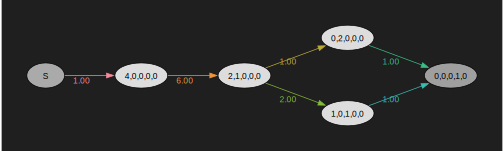

In [2]:
def coalescent(state, nr_samples=None):
    if not state.size:
        ipv = [([nr_samples]+[0]*nr_samples, 1)]
        return ipv
    else:
        transitions = []
        for i in range(nr_samples):
            for j in range(i, nr_samples):            
                same = int(i == j)
                if same and state[i] < 2:
                    continue
                if not same and (state[i] < 1 or state[j] < 1):
                    continue 
                new = state.copy()
                new[i] -= 1
                new[j] -= 1
                new[i+j+1] += 1
                transitions.append((new, state[i]*(state[j]-same)/(1+same)))
        return transitions

graph = ptd.Graph(callback=coalescent, nr_samples=4)

graph.plot()

In [3]:
graph.expectation()

INFO: building reward compute graph...


1.4999999999999996

In [4]:
rewards = graph.states().T
rewards

array([[0, 4, 2, 0, 1, 0],
       [0, 0, 1, 2, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0]], dtype=int32)

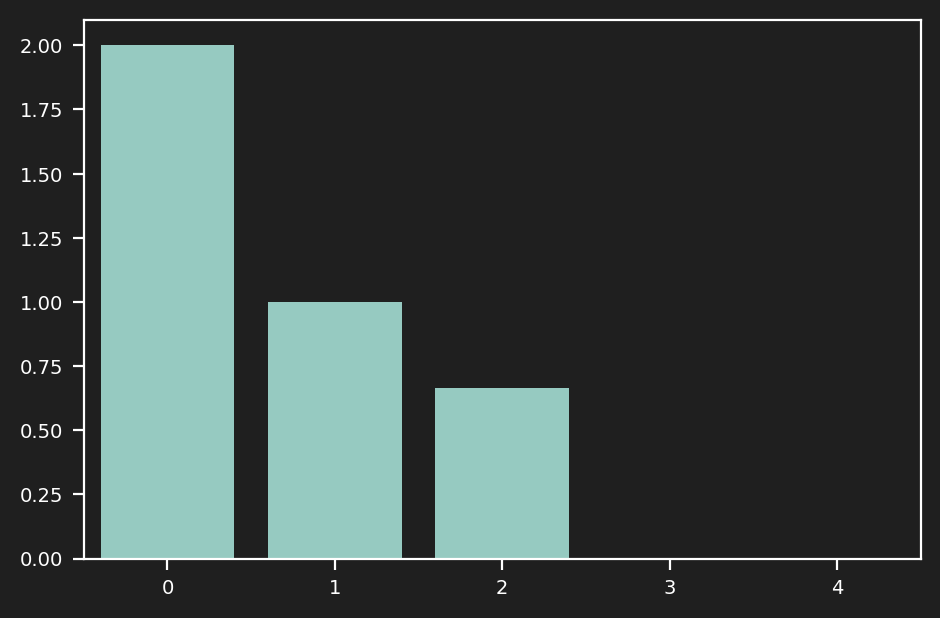

In [5]:
sfs = np.apply_along_axis(graph.expectation, 1, rewards)
sns.barplot(sfs) ;

## Make discrete

Turn state space for a continuous PTD into one for a discrete.

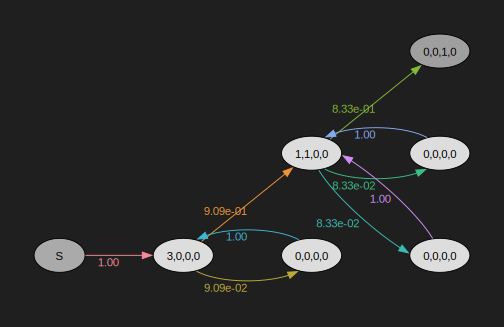

In [6]:
def make_discrete(mutation_graph, mutation_rate, skip_states=[], skip_slots=[]):
    """
    Takes a graph for a continuous distribution and turns
    it into a descrete one (inplace). Returns a matrix of
    rewards for computing marginal moments
    """

    mutation_graph = graph.copy()

    # save current nr of states in graph
    vlength = mutation_graph.vertices_length()

    # number of fields in state vector (assumes all are the same length)
    state_vector_length = len(mutation_graph.vertex_at(1).state())

    # list state vector fields to reward at each auxiliary node
    # rewarded_state_vector_indexes = [[] for _ in range(state_vector_length)]
    rewarded_state_vector_indexes = defaultdict(list)

    # loop all but starting node
    for i in range(1, vlength):
        if i in skip_states:
            continue
        vertex = mutation_graph.vertex_at(i)
        if vertex.rate() > 0: # not absorbing
            for j in range(state_vector_length):
                if j in skip_slots:
                    continue
                val = vertex.state()[j]
                if val > 0: # only ones we may reward
                    # add auxilliary node
                    mutation_vertex = mutation_graph.create_vertex(np.repeat(0, state_vector_length))
                    mutation_vertex.add_edge(vertex, 1)
                    vertex.add_edge(mutation_vertex, mutation_rate*val)
                    # print(mutation_vertex.index(), rewarded_state_vector_indexes[j], j)
                    # rewarded_state_vector_indexes[mutation_vertex.index()] = rewarded_state_vector_indexes[j] + [j]
                    rewarded_state_vector_indexes[mutation_vertex.index()].append(j)

    # print(rewarded_state_vector_indexes)

    # normalize graph
    weights_were_multiplied_with = mutation_graph.normalize()

    # build reward matrix
    rewards = np.zeros((mutation_graph.vertices_length(), state_vector_length))
    for state in rewarded_state_vector_indexes:
        for i in rewarded_state_vector_indexes[state]:
            rewards[state, i] = 1

    rewards = np.transpose(rewards)
    return mutation_graph, rewards



graph = ptd.Graph(callback=coalescent, nr_samples=3)

# self-transition rate:
# mutation_rate = 1e-8
mutation_rate = 0.1

# # clone graph to get one to modify:
# mutation_graph = graph.copy()

# add auxilliary states, normalize and return reward matrix:
mutation_graph, rewards = make_discrete(graph, mutation_rate)

# print(mutation_graph.expectation())
# print([mutation_graph.expectation(r) for r in rewards])

# print(rewards)
mutation_graph.plot()


# from functools import wraps

# def discrete(mutation_rate, skip_states=[], skip_slots=[]):
#     def decorator(graph_constructor):
#         @wraps(graph_constructor)
#         def wrapper(*args, **kwargs):
#             graph = graph_constructor(*args, **kwargs)
#             rewards = make_discrete(graph, mutation_rate)
#             return rewards
#         return wrapper
#     return decorator
    
# @discrete(mutation_rate=1)
# def foo():    
#     return coalescent(4)


# rewards = foo()
# rewards

In [7]:
discrete_graph, discrete_rewards= graph.discretize(reward_rate=0.1)

In [8]:
mutation_graph.states()

array([[0, 0, 0, 0],
       [3, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

In [9]:
rewards

array([[0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [10]:
graph.expectation() * 0.1


INFO: building reward compute graph...


0.13333333333333333

In [11]:
graph.expectation(np.sum(mutation_graph.states(), axis=0) * 0.1), 


(0.13333333333333333,)

INFO: building reward compute graph...


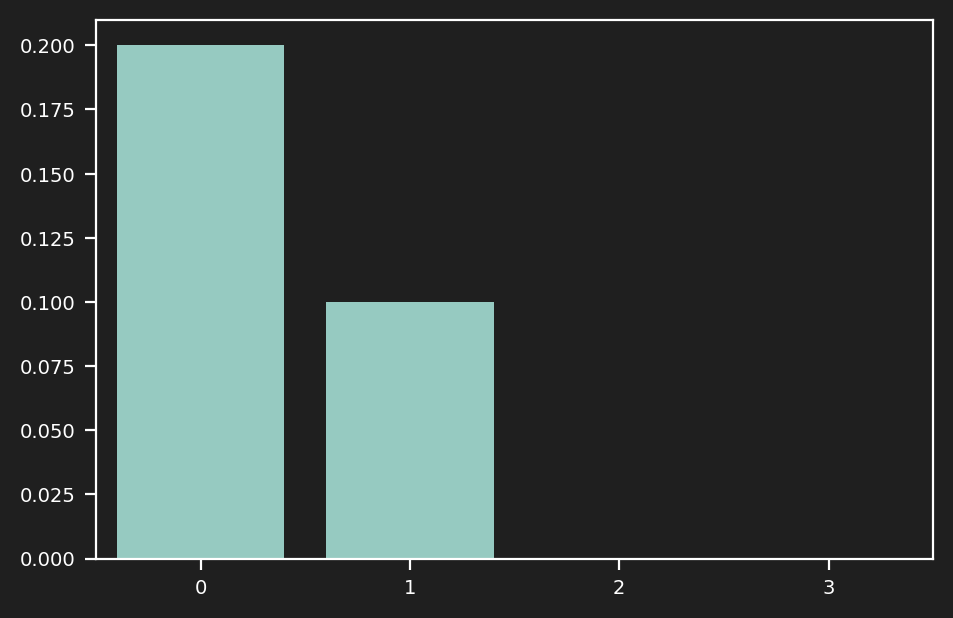

In [12]:
sfs = np.apply_along_axis(mutation_graph.expectation_discrete, 1, rewards)
sns.barplot(sfs) ;

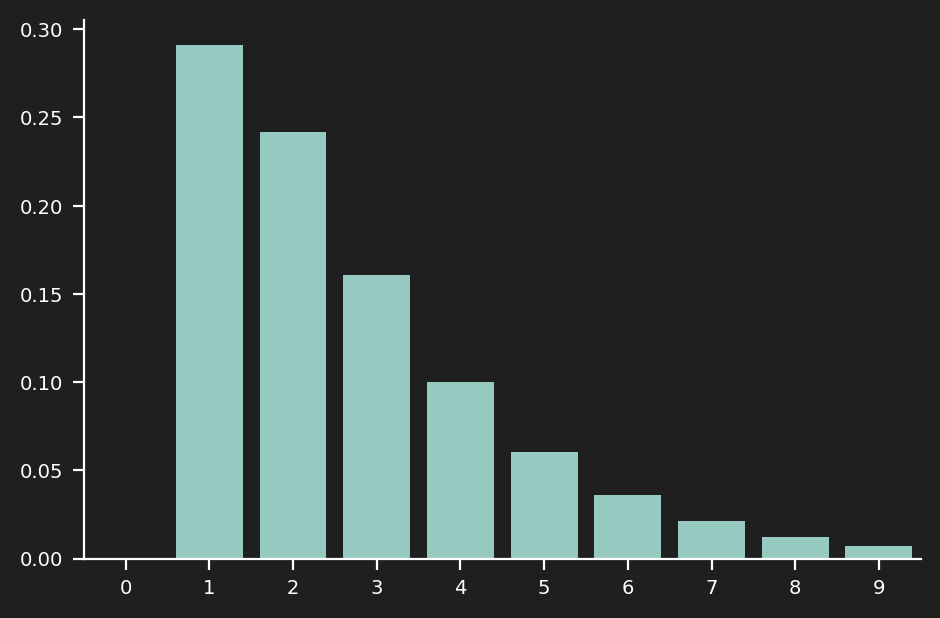

In [13]:
sns.barplot(mutation_graph.pdf(np.arange(10)))
sns.despine()

## Discrete joint prob

In [14]:

def discrete_joint_prob(_graph, reward_rates, precision=1e-15, return_fun=False, return_graph=False):

    starting_vertex = graph.starting_vertex()
    reward_dims = len(reward_rates(starting_vertex.state())) - 1 # a bit of a hack. -1 to not count trash rate...

    orig_state_vector_length = len(graph.vertex_at(1).state())
    state_vector_length = orig_state_vector_length + reward_dims

    state_indices = np.arange(orig_state_vector_length)
    reward_indices = np.arange(orig_state_vector_length, state_vector_length)

    new_graph = ptd.Graph(state_vector_length)
    # new_starting_vertex = new_graph.vertex_at(1)
    new_starting_vertex = new_graph.starting_vertex()

    null_rewards = np.zeros(reward_dims)

    index = 0
    # add edges from starting vertex (IPV)
    for edge in starting_vertex.edges():
        new_starting_vertex.add_edge(
          new_graph.find_or_create_vertex(np.append(edge.to().state(), null_rewards).astype(int)), 1)

    index = index + 1
    
    trash_rates = {}
    t_vertex_indices = np.array([], dtype=int)
    while index < new_graph.vertices_length():

        new_vertex = new_graph.vertex_at(index)
        new_state = new_vertex.state()
        state = new_vertex.state()[state_indices]
        vertex = graph.find_vertex(state)

        # non-mutation transitions (coalescence)
        for edge in vertex.edges():
            new_child_state = np.append(edge.to().state(), new_state[reward_indices])

            if np.all(new_state == new_child_state):
                continue
                
            new_child_vertex = new_graph.find_or_create_vertex(new_child_state)
            # cat(new_child_vertex$state, "\n")
            new_vertex.add_edge(new_child_vertex, # if I use create_vertex here, I cannot find it again with find_vertex...
                edge.weight()
            )

            # if new child was absorbing, record at "t-states":
            if not graph.find_vertex(new_child_state[state_indices]).edges():
                t_vertex_indices = np.append(t_vertex_indices, new_child_vertex.index()) 

        # mutation transitions
        current_state = new_state[state_indices]
        current_rewards = new_state[reward_indices]
        rates = reward_rates(current_state, current_rewards) # list of all allowed mutation transition rates with trash rate appended

        trash_rates[index] = rates[reward_dims]
        for i in range(reward_dims):
            rate = rates[i]
            if rate > 0:
                new_rewards = current_rewards
                new_rewards[i] = new_rewards[i] + 1
                new_child_vertex = new_graph.find_or_create_vertex(np.append(current_state, new_rewards))
                # stopifnot(sum(new_child_vertex$state) > 4)
                # cat(new_child_vertex$state, "\n")
                new_vertex.add_edge(
                    new_child_vertex, # if I use create_vertex here, I cannot find it again with find_vertex...
                    rate
                    )
                
                # # if new child was absorbing, record at "t-states":                
                # if (length(edges(find_vertex(graph, new_child_state[state_indices]))) == 0) {
                #     t_vertex_indices = c(t_vertex_indices, new_child_vertex$index) 

        index = index + 1 

        if not index % 10_000:
            graph_size = new_graph.vertices_length()
            print(f'index: {index:>6}      vertices: {graph_size:>6}      ratio: {graph_size/index:>4.2}', file=sys.stderr)
            sys.stderr.flush()

    # trash states
    trash_vertex = new_graph.find_or_create_vertex(np.repeat(0, state_vector_length))
    trash_loop_vertex = new_graph.create_vertex(np.repeat(0, state_vector_length))
    trash_vertex.add_edge(trash_loop_vertex, 1)
    trash_loop_vertex.add_edge(trash_vertex, 1)

    # add trash edges
    for i, rate in trash_rates.items():
        new_graph.vertex_at(i).add_edge(trash_vertex, rate) 

    # add edges from t-states to new final absorbing
    new_absorbing = new_graph.create_vertex(np.repeat(0, state_vector_length))

    t_vertex_indices = np.unique(t_vertex_indices)
    
    for i in t_vertex_indices:
        new_graph.vertex_at(i).add_edge(new_absorbing, 1)

    # normalize graph                            
    weights_were_multiplied_with = new_graph.normalize()

    if return_graph:                           
        return(new_graph)                                             

    # time spent in each of the the t-states at time stop or after some appropriately large time (these are the joint probs)

    prev = None
    for decade in range(1000):
        accum_time_all = new_graph.accumulated_visiting_time(decade*10)
        accum_time = np.array(accum_time_all)[t_vertex_indices]
        if prev is not None and np.all(np.abs(accum_time - prev) < precision):
            break
        prev = accum_time

    assert decade < 100

    class Fun():

        def __init__(self, new_graph, t_vertex_indices):
            self.new_graph = new_graph
            self.t_vertex_indices = t_vertex_indices

        def __call__(self, tup):

        # def __call__(self, stop):
        #     accum_time_all = self.new_graph.accumulated_visiting_time(stop)
        #     accum_time = np.array(accum_time_all)[self.t_vertex_indices]

        #     states = new_graph.states()
        #     state_reward_matrix = states[self.t_vertex_indices, :][:, reward_indices]
        #     joint_probs = pd.DataFrame(state_reward_matrix)
        #     index_cols = joint_probs.columns.values.tolist()
        #     joint_probs['time'] = stop
        #     joint_probs['prob'] = accum_time
        #     joint_probs.set_index(index_cols, inplace=True)

            return joint_probs 

    fun = Fun(new_graph, t_vertex_indices)

    if return_fun:
        return fun

    return fun(decade*10).drop(columns='time')

    # I can test if the graph is acyclic and if so, use accumulated_residence_time instead?


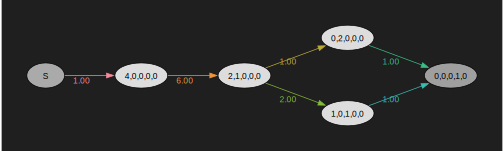

In [15]:
graph = ptd.Graph(callback=coalescent, nr_samples=4)
graph.plot()

In [16]:
graph.variance()

INFO: building reward compute graph...


1.1388888888888893

In [17]:
# gam = graph.as_matrices()
# gam

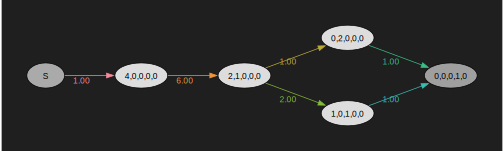

In [18]:
graph.plot()

In [19]:
graph.pdf(10)

8.140105759241116e-05

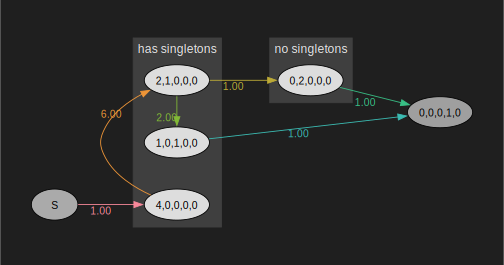

In [20]:
graph.plot(
            nodesep=0.5,
             subgraphfun=lambda state: 'has singletons' if np.all(state[0] > 0) else 'no singletons',
               )

In [21]:
def reward_callback(state, current_rewards=None, mutation_rate=1, reward_limit=10, tot_reward_limit=np.inf):

    reward_limits = np.append(np.repeat(reward_limit, len(state)-1), 0)
    
    reward_dims = len(reward_limits)
    if current_rewards is None:
        current_rewards = np.zeros(reward_dims)

    reward_rates = np.zeros(reward_dims)
    trash_rate = 0
    
    for i in range(reward_dims):
        rate = state[i] * mutation_rate 
        r = np.zeros(reward_dims)
        r[i] = 1
        if np.all(current_rewards + r <= reward_limits) and np.sum(current_rewards + r) <= tot_reward_limit:
            reward_rates[i] = rate
        else:
            trash_rate = trash_rate + rate

    return np.append(reward_rates, trash_rate)

joint_probs = discrete_joint_prob(graph, reward_callback)

joint_probs    

NameError: name 'joint_probs' is not defined

In [ ]:
def reward_callback(state, current_rewards=None, mutation_rate=1, reward_limit=10, tot_reward_limit=np.inf):

    reward_limits = np.append(np.repeat(reward_limit, len(state)-1), 0)
    
    reward_dims = len(reward_limits)
    if current_rewards is None:
        current_rewards = np.zeros(reward_dims)

    reward_rates = np.zeros(reward_dims)
    trash_rate = 0
    
    for i in range(reward_dims):
        rate = state[i] * mutation_rate 
        r = np.zeros(reward_dims)
        r[i] = 1
        if np.all(current_rewards + r <= reward_limits) and np.sum(current_rewards + r) <= tot_reward_limit:
            reward_rates[i] = rate
        else:
            trash_rate = trash_rate + rate

    return np.append(reward_rates, trash_rate)


def joint_pmf(graph, rate_fun, reward_limit=10):
    """
    Returns a joint probability mass function for the graph
    """

    def reward_callback(state, current_rewards=None, mutation_rate=1, reward_limit=10):

        reward_limits = np.append(np.repeat(reward_limit, len(state)-1), 0)
        
        reward_dims = len(reward_limits)
        if current_rewards is None:
            current_rewards = np.zeros(reward_dims)

        reward_rates = np.zeros(reward_dims)
        trash_rate = 0
        
        for i in range(reward_dims):
            rate = rate_fun(state[i])
            r = np.zeros(reward_dims)
            r[i] = 1
            if np.all(current_rewards + r <= reward_limits):
                reward_rates[i] = rate
            else:
                trash_rate = trash_rate + rate

        return np.append(reward_rates, trash_rate)

    return discrete_joint_prob(graph, reward_callback, return_fun=True)



fun = joint_pmf(graph, lambda x: x*1, reward_limit=10)
fun

In [ ]:
joint_probs.at[(0, 1, 0, 0, 0), 'prob']

0.0222222222222207

In [ ]:
def joint_pmf(graph, reward_callback):
    df = 
    df.loc[(0, 1, 0, 0)]


In [ ]:
outcomes = np.matrix(list(map(list, joint_probs.index.values)))
probs = joint_probs['prob'].values
with_deficit = probs @ outcomes
with_deficit = with_deficit[:,:nr_samples-1]
no_deficit = np.matrix([2/x for x in range(1, 4)])
deficit = (no_deficit - with_deficit) / no_deficit
deficit

NameError: name 'nr_samples' is not defined

In [ ]:
joint_prob_at_time = discrete_joint_prob(graph, reward_rates, return_fun=True)
joint_prob_at_time

<__main__.discrete_joint_prob.<locals>.Fun at 0x10900b390>

In [ ]:
df = pd.concat([joint_prob_at_time(t) for t in np.arange(1, 10, 1)])
df.head(20)

time      prob
0 1 2 3 4                
0 0 0 0 0     1  0.001899
  1 0 0 0     1  0.000081
1 0 0 0 0     1  0.000349
    1 0 0     1  0.000095
  1 0 0 0     1  0.000078
    1 0 0     1  0.000002
0 0 0 0 0     2  0.014296
  1 0 0 0     2  0.001170
1 0 0 0 0     2  0.005031
    1 0 0     2  0.001562
  1 0 0 0     2  0.001349
    1 0 0     2  0.000074
0 0 0 0 0     3  0.035299
  1 0 0 0     3  0.004107
1 0 0 0 0     3  0.017660
    1 0 0     3  0.006096
  1 0 0 0     3  0.005474
    1 0 0     3  0.000402
0 0 0 0 0     4  0.056682
  1 0 0 0     4  0.008252

In [ ]:
df.pivot(columns='time')

prob                                                    \
time              1         2         3         4         5         6   
0 1 2 3 4                                                               
0 0 0 0 0  0.001899  0.014296  0.035299  0.056682  0.073525  0.084901   
  1 0 0 0  0.000081  0.001170  0.004107  0.008252  0.012439  0.015893   
1 0 0 0 0  0.000349  0.005031  0.017660  0.035485  0.053489  0.068342   
    1 0 0  0.000095  0.001562  0.006096  0.013347  0.021546  0.029038   
  1 0 0 0  0.000078  0.001349  0.005474  0.012319  0.020287  0.027735   
    1 0 0  0.000002  0.000074  0.000402  0.001097  0.002069  0.003124   

                                         
time              7         8         9  
0 1 2 3 4                                
0 0 0 0 0  0.091839  0.095772  0.097883  
  1 0 0 0  0.018383  0.020012  0.021003  
1 0 0 0 0  0.079047  0.086051  0.090314  
    1 0 0  0.034965  0.039188  0.041969  
  1 0 0 0  0.033737  0.038080  0.040977  
    1 0 0  0.004086  0.004862  0.005431

In [ ]:
new_graph = discrete_joint_prob(graph, reward_rates, return_graph=True)

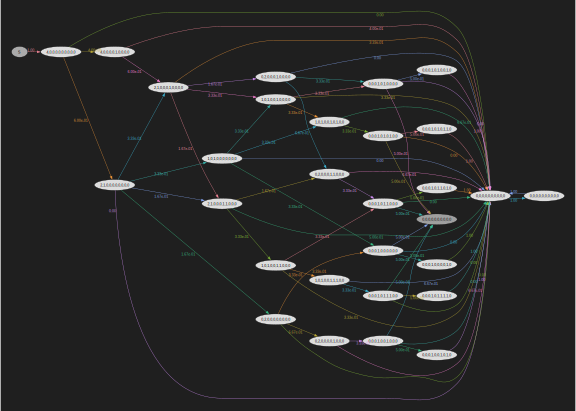

In [ ]:
new_graph.plot(size=(8, 8), ranksep=0.6, nodesep=0.3, rainbow=True)

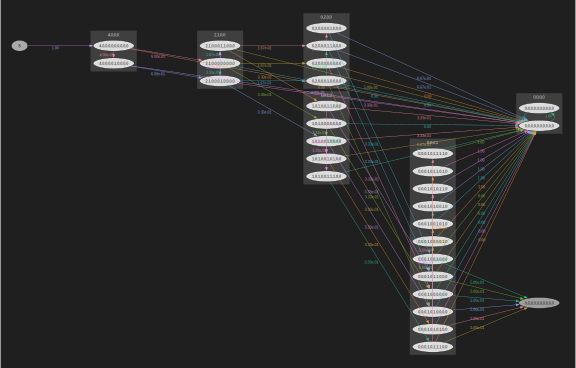

In [ ]:

new_graph.plot(size=(8, 8), ranksep=3, nodesep=0.3, rainbow=True,
    subgraphfun=lambda state: ','.join(map(str, state[:nr_samples])),
    splines='line',
)

## Finite Markov Chains (FMC)

### Distribution of steps spent in a state

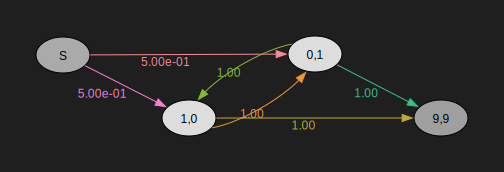

In [ ]:
def loop():

    def callback(state):
        if not state.size:
            return [([1, 0], 0.5), ([0, 1], 0.5)]

        transitions = []

        if state.sum() > 1:
            return transitions

        if state[0] == 0:
            new_state = state.copy()
            new_state[0] += 1
            new_state[1] -= 1            
            transitions.append((new_state, 1))
        else:
            new_state = state.copy()
            new_state[0] -= 1
            new_state[1] += 1
            transitions.append((new_state, 1))

        new_state = state.copy()
        new_state[0] = 9
        new_state[1] = 9
        transitions.append((new_state, 1))

        return transitions

    graph = ptd.Graph(callback=callback)
    return graph
        
graph = loop()
graph.plot(rainbow=True)


In [ ]:

def loop_reward_rates(new_state, current_rewards=None, mutation_rate=None, reward_limit=10, tot_reward_limit=5):

    target_state = np.array([0, 1])

    reward_limits = np.append(np.repeat(reward_limit, len(new_state)-1), 0)
    
    reward_dims = len(reward_limits)
    if current_rewards is None:
        current_rewards = np.zeros(reward_dims)

    result = np.zeros(reward_dims)
    trash_rate = 0
    
    for i in range(reward_dims):
        rate = new_state[i] * mutation_rate 
        r = np.zeros(reward_dims)
        r[i] = 1
        
        if np.all(new_state == target_state) and np.sum(current_rewards + r) <= tot_reward_limit:
        # if np.all(current_rewards + r <= reward_limits) and np.sum(current_rewards + r) <= tot_reward_limit:
            result[i] = rate
        else:
            trash_rate = trash_rate + rate

    return np.append(result, trash_rate)


# reward_rates = partial(coalescent_reward_rates, mutation_rate=1, reward_limit=1, tot_reward_limit=2)
reward_rates = partial(loop_reward_rates, mutation_rate=1, reward_limit=2)

joint_probs = discrete_joint_prob(graph, reward_rates)

joint_probs#.head()

prob
0 1          
0 0  0.500000
  1  0.125000
  2  0.046875
  3  0.017578
  4  0.006592
  5  0.002472

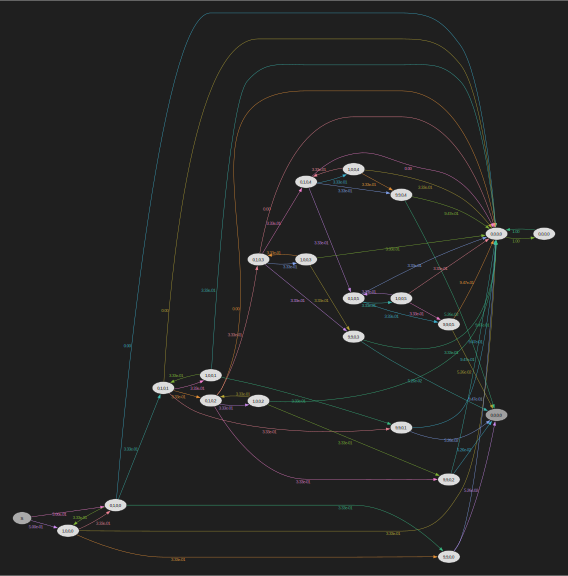

In [ ]:
discrete_joint_prob(graph, reward_rates, return_graph=True).plot(size=(8, 8), ranksep=1, nodesep=0.5)

### Nr of runs of a particular state

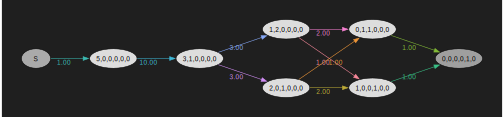

In [ ]:
sample_size = 5
graph = coalescent(sample_size)
graph.plot(rainbow=True)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0.5
[0.0, 1.5, 1.6666666666666654, 0.9999999999999998, 0.9999999999999997, 1.5000000000000009, 1.5000000000000009, 0.0, 0.3333333333333333, 0.16666666666666666, 0.49999999999999983, 0.5000000000000001, 0.16666666666666663, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.5, 0.5, 0.5, 0.5]


INFO: building reward compute graph...


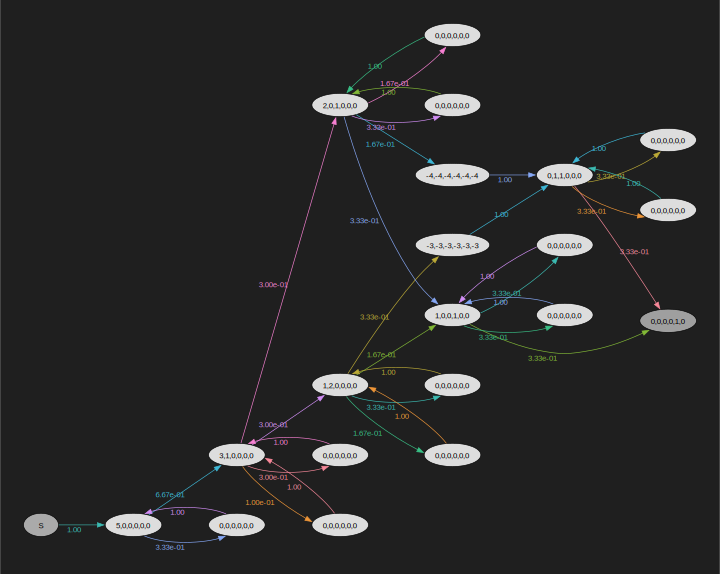

In [ ]:



new_graph = graph.copy()

target_vertex = new_graph.vertex_at(5)

new_vertices = []
for vertex in new_graph.vertices():
    for edge in vertex.edges():
        if edge.to() == target_vertex:
            # create new vertex
            new_vertex = new_graph.find_or_create_vertex(np.repeat(-vertex.index(), vertex.state().size))

            # make edge point that instead
            edge.update_to(new_vertex)

            # add edge from new_vertex to target_vertex with weight 1
            new_vertex.add_edge(target_vertex, 1)

            # keep index of added vertex
            new_vertices.append(new_vertex.index())

# rewards = make_discrete(new_graph, mutation_rate, skip=new_vertices)
rewards = make_discrete(new_graph, 1, skip_states=new_vertices)

print(rewards)

rev = np.zeros(new_graph.vertices_length())
for i in new_vertices:
    rev[i] = 1

print(new_graph.expectation(rev))
# print(new_graph.accumulated_visiting_time(10))
print(new_graph.accumulated_visits_discrete(1000))

new_graph.plot(rainbow=True, size=(10, 10))


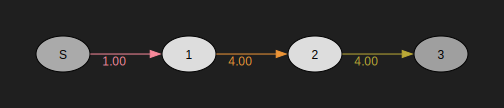

In [67]:
def loop(state):
    if not state.size:
        return [([1], 1)]
    elif state[0] < 3:
        return [(state+1, 4)]
    return []

graph = ptd.Graph(callback=loop)
graph.plot()

In [68]:
graph.expectation(), graph.expected_waiting_time()

INFO: building reward compute graph...


(0.5, [0.5, 0.5, 0.25, 0.0])

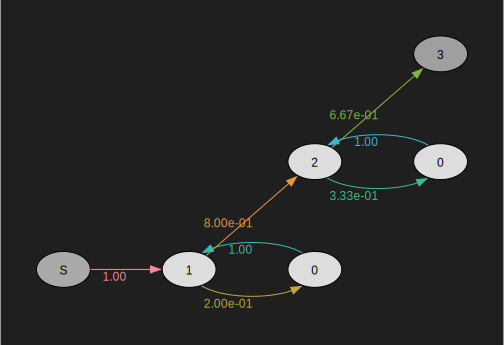

In [64]:

discr_graph, discr_rewards = graph.discretize(reward_rate=1)
discr_graph.plot()


INFO: building reward compute graph...


(0.5, [0.5, 0.5, 0.25, 0.0])

In [58]:
np.sum(discr_rewards, axis=0)

array([0, 0, 0, 0, 1, 1])

In [61]:
discr_graph.expected_waiting_time()

[3.4999999999999996,
 3.4999999999999996,
 1.9999999999999996,
 0.0,
 4.5,
 2.9999999999999996]

In [59]:
discr_graph.expectation(np.sum(discr_rewards, axis=0))

0.7499999999999999

In [60]:
np.sum(discr_rewards, axis=0)

array([0, 0, 0, 0, 1, 1])

In [44]:
discr_graph.expectation(discr_rewards)


TypeError: expectation(): incompatible function arguments. The following argument types are supported:
    1. (self: ptdalgorithms.ptdalgorithmscpp_pybind.Graph, rewards: list[float] = []) -> float

Invoked with: <Graph (6 vertices)>, array([[0, 0, 0, 0, 1, 1]])

In [ ]:
graph.expectation(np.sum(discr_rewards, axis=1))

array([2])

In [42]:
discr_graph.expectation(rewards = np.sum(discr_rewards, axis=1))
#graph.expectation(np.sum(discr_rewards, axis=1) * 0.1)




RuntimeError: Failed: Rewards must match the number of vertices. Expected 6, got 1

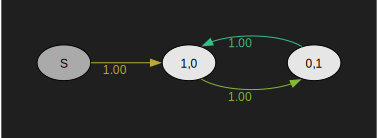

In [ ]:
def loop():

    def callback(state):
        transitions = []
        if state[0] == 0:
            new_state = state[:]
            new_state[0] += 1
            new_state[1] -= 1
            transitions.append((new_state, 1))
        else:
            new_state = state[:]
            new_state[0] -= 1
            new_state[1] += 1
            transitions.append((new_state, 1))
        return transitions

    graph = ptd.Graph(callback=callback, initial=[1, 0])
    return graph
        
graph = loop()
graph.plot(rainbow=True)

### I could add an fmc argument that adds a slot to initial and increments that for all states returned by callback

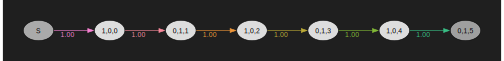

In [ ]:
def loop():

    def callback(state):

        if not state.size:
            return [([1, 0, 0], 1)]

        if state[2] == 5:
            return []

        if state[0] == 0:
            new_state = state[:]
            new_state[0] += 1
            new_state[1] -= 1
            new_state[2] += 1
            return [(new_state, 1)]
        else:
            new_state = state[:]
            new_state[0] -= 1
            new_state[1] += 1
            new_state[2] += 1
            return [(new_state, 1)]

    graph = ptd.Graph(callback=callback)
    return graph
        
graph = loop()
graph.plot(rainbow=True)

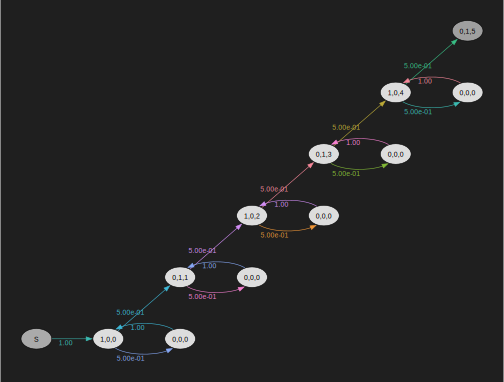

In [ ]:
rewards = make_discrete(graph, 1, skip_slots=[graph.state_length()-1])
graph.plot(rainbow=True)


In [ ]:
graph.states()

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 1],
       [1, 0, 2],
       [0, 1, 3],
       [1, 0, 4],
       [0, 1, 5],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)

In [ ]:
graph.accumulated_visits_discrete(1000)


[0.0,
 2.0,
 1.9999999999999998,
 2.0,
 1.9999999999999996,
 2.0,
 0.0,
 1.0,
 0.9999999999999999,
 1.0,
 0.9999999999999998,
 1.0]

### Length of longest run of a state in an FMC

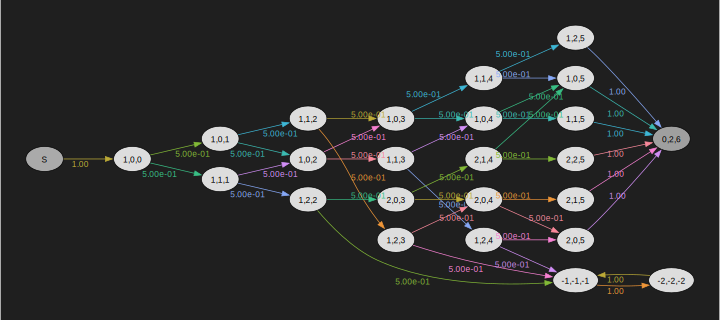

In [ ]:
# D: A->A
# A: A->B
# B: B->A
# D: B->B

def maxlen():

    def callback(state):

        A, B, C, D = 1, 1, 1, 1

        if not state.size:
            return [([1, 0, 0], 1)]

        x, y, z = state
        
        max_y, max_z = 2, 6

        absorb = (0, max_y, max_z)
        # absorb = (0, 0, 0)
        if np.all(state == absorb):
            return []

        trash1, trash2 = (-1, -1, -1), (-2, -2, -2)
        # trash1, trash2 = (0, 0, 0), (0, 0, 0)
        if np.all(state == trash1):
            return [(trash2, 1)]
        if np.all(state == trash2):
            return [(trash1, 1)]

        if z+1 == max_z:
            return [(absorb, 1)]
        
        if y == 0:
            return [((x, y, z+1), C/(B+C)),
                    ((x, y+1, z+1), A/(A+D))]
        if y == max_y:
            return [(trash1, D/(A+D)), # trash
                    ((y, 0, z+1), B/(B+C))]

        return [((x, y+1, z+1), D/(A+D)),
                ((y, 0, z+1), B/(B+C))]

    graph = ptd.Graph(callback=callback)
    return graph
        
graph = maxlen()
graph.plot(rainbow=True, ranksep=1, nodesep=0.3, size=(10, 10))

In [ ]:
graph.states()

array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 1],
       [1, 0, 2],
       [1, 1, 2],
       [1, 2, 2],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 1],
       [0, 0, 2],
       [0, 1, 2],
       [0, 2, 2]], dtype=int32)

In [ ]:
joint_probs %>% filter(V1==1, V2==0, V3==1) 

V1,V2,V3,V4,accum_time
<int>,<int>,<int>,<int>,<dbl>
1,0,1,0,0.03111111


With `sample_size <- 4`, `mutation_rate <- 1`, `reward_limits <- rep(20, sample_size-1)`, and `tot_reward_limit <- Inf`, tothe marginal probabilities match the SFS:

```
c(sum(joint_probs$V1 * joint_probs$accum_time), 
  sum(joint_probs$V2 * joint_probs$accum_time), 
  sum(joint_probs$V3 * joint_probs$accum_time))
```

```
1.99981743759578 0.998152771395828 0.666638375487117
```

and the joint prob of a singleton and a trippleton is:

```
1	0	1	0.03111111
```

which is exactly what we also get with `reward_limits <- rep(1, sample_size-1)`.

Setting `tot_reward_limit <- 2` also produces `0.03111111`.

In [ ]:
joint_probs %>% rename_with(gsub, pattern="V", replacement="ton") %>% group_by(ton1, ton2) %>% summarize(prob=sum(accum_time), .groups="keep")

ton1,ton2,prob
<int>,<int>,<dbl>
0,0,0.12222222
0,1,0.04259259
1,0,0.12666667
1,1,0.03777778


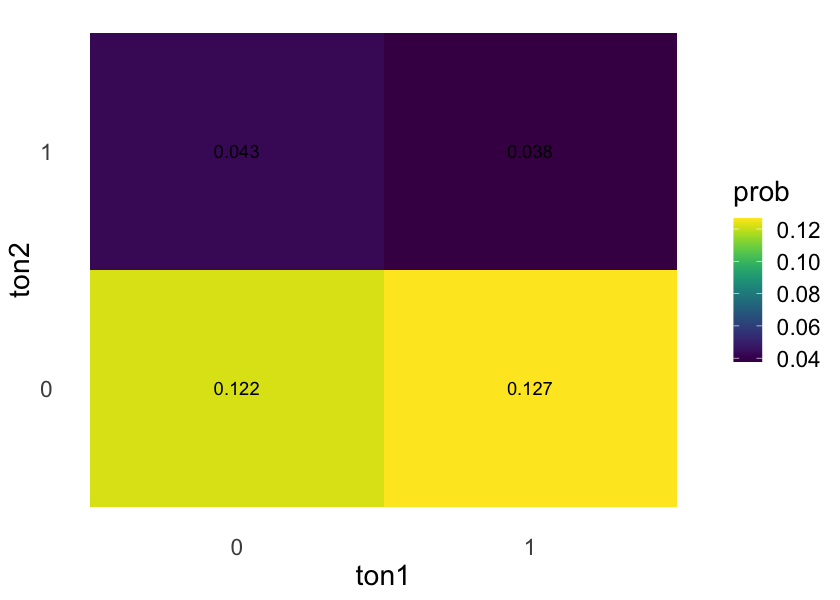

In [ ]:
plot_df <- joint_probs %>% 
    rename_with(gsub, pattern="V", replacement="ton") %>% 
    group_by(ton1, ton2) %>% 
    summarize(prob=sum(accum_time), .groups="keep")

for (colname in colnames(plot_df)) {
    if (startsWith(colname, 'ton')) {
        plot_df[[colname]] <- as.factor(plot_df[[colname]])
    }
}

ggplot(plot_df, aes(x=ton1, y=ton2)) +
    geom_tile(aes(fill = prob)) + 
    geom_text(aes(label = round(prob, 3))) +
    scale_fill_viridis() +
    # scale_fill_distiller(palette = 'PiYG',direction = 1,
    #                 limit=max(abs(plot_df$prob)) * c(-1, 1)
    #                 ) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

In [ ]:
# map_state <- function(state) {
#         lumped_state <- c(sum(state[1:sample_size]), head(state, sample_size) * (reward_limits - tail(state, sample_size)))
#         lumped_state <- as.integer(lumped_state)
#         return(lumped_state)
# }
# label_fun <- function(state, index) {
#     return(paste(map_state(state), collapse=""))
# }

# if (vertices_length(graph) < 30) {    
#     new_graph <- discrete_joint_prob(graph, reward_rates, return_graph=TRUE)

#     plot_graph(graph_as_matrix(new_graph), size=c(10, 10), align=TRUE, #rainbow=TRUE,
#                    fontsize=26, ranksep=4, nodesep=0.9, rankdir="LR",
#               subgraphs=TRUE, subgraphfun=label_fun,
#               # subgraphs=TRUE, subgraphfun=function(state, index) sum(head(state, sample_size)),
#             splines='line'
#               )  
# }           

In [ ]:
graph_vec <- c()
new_graph_vec <- c()
sample_sizes <- 4:15
for (sample_size in sample_sizes) {
    graph <- standard_coalescent(sample_size)
    graph_vec <- c(graph_vec, vertices_length(graph))
    reward_limits <- c(rep(1, sample_size-1), 0)
    tot_reward_limit <- Inf
    new_graph <- discrete_joint_prob(graph, reward_rates, return_graph=TRUE)
    # new_graph <- discrete_joint_prob(graph, reward_limits, mutation_rate, reward_possible, tot_reward_limit=tot_reward_limit, return_graph=TRUE)
    new_graph_vec <- c(new_graph_vec, vertices_length(new_graph))
    # new_graph_vec <- c(new_graph_vec, length(unique(apply(apply(states(new_graph), 1, map_state), 2, paste, collapse=""))))
}

1000 1311 
1000 1443 
2000 2178 
1000 1579 
2000 2687 
3000 3185 
1000 1656 
2000 2979 
3000 3930 
4000 4451 


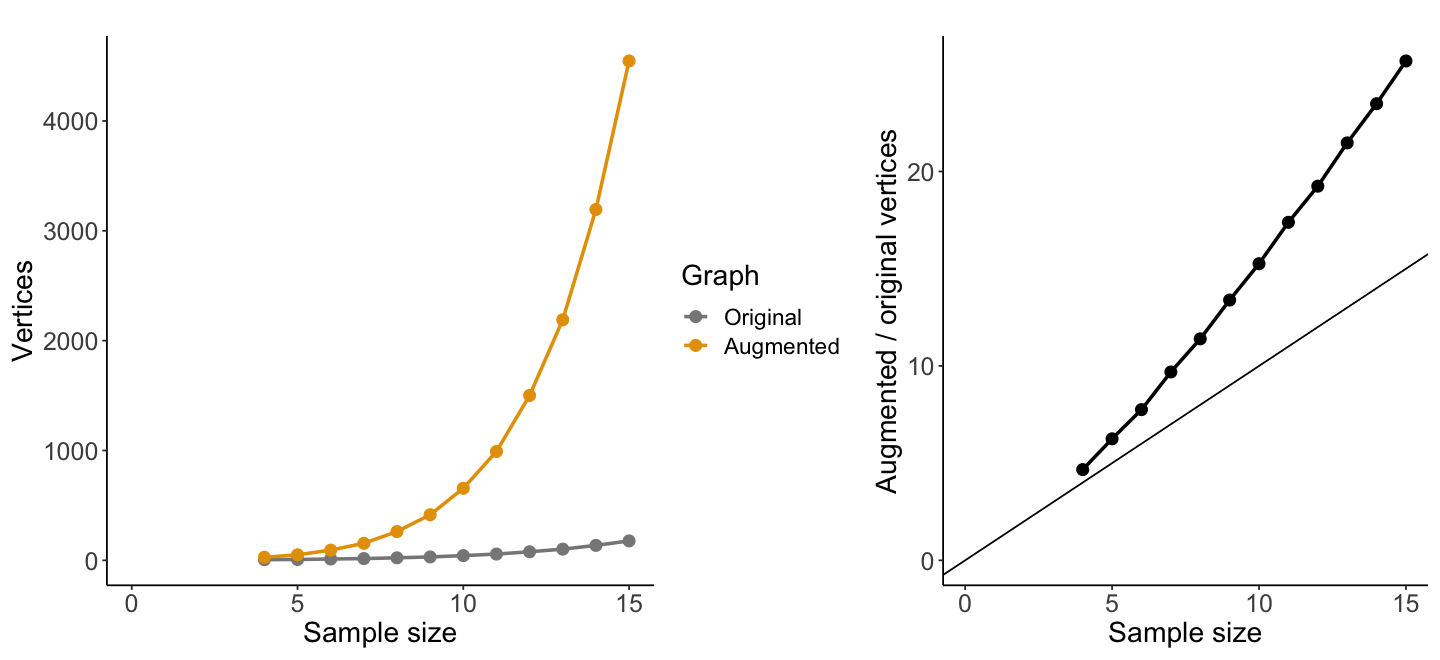

In [ ]:
theme_set(theme_bw() + theme(axis.line = element_line(colour = "black"),
                 text=element_text(size=17),
                 axis.text = element_text(size=15),
                 plot.margin = unit(c(0.3,0.1,0.1,0.1), "inch")))
palette <- c("#888888", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
opt <- options(repr.plot.width=7, repr.plot.height=5,
               ggplot2.discrete.colour=palette, ggplot2.discrete.fill=palette) ;
despine <-  theme(panel.border = element_blank(), 
                 panel.grid.major = element_blank(),
                 panel.grid.minor = element_blank())

library(gridExtra)
df <- data.frame(
  samples = sample_sizes,
  graph_states = graph_vec,
  new_graph_states =new_graph_vec
)
df_long <- pivot_longer(df, c(graph_states, new_graph_states))
p1 <- ggplot(df_long, aes(x=samples, y=value, color=name)) +
    geom_line(linewidth=1) + geom_point(size=3) + 
    despine +
    xlim(0, NA) + ylim(0, NA) +
    labs(x="Sample size", y="Vertices", color="Graph") +
    scale_color_discrete(labels = c("Original", "Augmented"))
p2 <- ggplot(df, aes(x=samples, y=new_graph_vec / graph_vec)) + 
    geom_line(linewidth=1) + geom_point(size=3) + 
    geom_abline(slope=1, intercept=0) +
    # geom_abline(slope=0.25, intercept=1.5) +
    despine +
    xlim(0, NA) + ylim(0, NA) +
    labs(x="Sample size", y="Augmented / original vertices", color="Graph")

opt <- options(repr.plot.width=12, repr.plot.height=5.5)
grid.arrange(p1, p2, nrow = 1, widths = 3:2)
options(opt) ;

In [ ]:
# nr_states_vec <- c()
# nr_lumped_states_vec <- c()
# sample_sizes <- 4:10
# for (sample_size in sample_sizes) {
#     graph <- standard_coalescent(sample_size)
#     state_length <- length(vertex_at(graph, 1)$state)
#     # last state index is absorbing where no rewards can be earned
#     reward_limits <- c(rep(1, state_length-1), 0)    
#     new_graph <- discrete_joint_prob(graph, reward_rates, return_graph=TRUE)
#     # new_graph <- discrete_joint_prob(graph, reward_limits, mutation_rate, reward_possible, return_graph=TRUE)
#     nr_states_vec <- c(nr_states_vec, vertices_length(new_graph))
#     nr_lumped_states_vec <- c(nr_lumped_states_vec, length(unique(apply(apply(states(new_graph), 1, map_state), 2, paste, collapse=""))))
# }
# df <- data.frame(
#   samples = sample_sizes,
#   nr_states = nr_states_vec,
#   nr_lumped_states =nr_lumped_states_vec
# )
# df_long <- pivot_longer(df, c(nr_states, nr_lumped_states))
# ggplot(df_long, aes(x=samples, y=value, hue=name)) + geom_line() + geom_point()

## Two-locus ARG

In [ ]:
Rcpp::sourceCpp("./cpp/index_prop_mapping.cpp")

two_locus_arg <- function(s, N, R) {

    # state vector length
    n <- (s+1)**2

    graph <- create_graph(n)
    index <- 1
    # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
    state <- rep(0, n)
    state[props_to_index_two_locus(s, 1, 1, 1)] <- s
    first_vertex <- find_or_create_vertex(graph, state) # assumes that p=2
    add_edge(starting_vertex(graph), first_vertex, 1)

    index <- 2
    while (index <= vertices_length(graph)) {

      vertex <- vertex_at(graph, index)
      state <- vertex$state

      count <- 0
      for (i in 1:n) {
          count <- count + state[i]
      }
      if (count <= 1) {
          # Only one lineage, stop
          index <- index + 1
          next
      }    

      for (i in 1:n) {
        if (state[i] == 0) next

        conf_i <- index_to_props_two_locus(s, i)

        # coalescence #########################
        for (j in i:n) {
          if (state[j] == 0) next
            
          conf_j <- index_to_props_two_locus(s, j)

          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            rate <- state[i] * (state[i] - 1) / 2 / N
          } else {
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            rate <- state[i] * state[j] / N
          }

          child_state <- state
        
          # lineages with index i and j coalesce:  
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          stopifnot(conf_i$descendants_l1+conf_j$descendants_l1 <= s)
          stopifnot(conf_i$descendants_l2+conf_j$descendants_l2 <= s)

          # coalescene into lineage with index k
          k = props_to_index_two_locus(s, conf_i$descendants_l1+conf_j$descendants_l1, conf_i$descendants_l2+conf_j$descendants_l2)
          child_state[k] <- child_state[k] + 1

          child_vertex <- find_or_create_vertex(graph, child_state)
          add_edge(vertex, child_vertex, rate)

        }
        

        # recombination #######################
        if (state[i] > 0 && conf_i$descendants_l1 > 0 && conf_i$descendants_l2 > 0) {

          # TODO: make sure this should not be R * state[i]
          rate <- R #* state[i] 
          child_state <- state

          # a lineage with index i recombines to produce lineages with index k and l
          k = props_to_index_two_locus(s, conf_i$descendants_l1, 0)
          l = props_to_index_two_locus(s, 0, conf_i$descendants_l2)
          child_state[i] <- child_state[i] - 1
          child_state[k] <- child_state[k] + 1
          child_state[l] <- child_state[l] + 1
            
          child_vertex <- find_or_create_vertex(graph, child_state)
          add_edge(vertex, child_vertex, rate)
        }

      }

      index <- index + 1

      # if ((index %% 50) == 0) {
      #   cat(index, vertices_length(graph), "\n")
      # }

    }
    
    return(graph)
}

In [ ]:
arg_reward_rates <- function(new_state, current_rewards, mutation_rate, reward_limit, locus_ton_reward_limit)
{    
    reward_limits <- c(rep(reward_limit, length(new_state)-1), 0)
    reward_limits <- c(reward_limits, reward_limits) # duplicate to account for separate mutations at each locus

    reward_dims <- length(reward_limits)
    if (is.null(current_rewards))
        current_rewards <- rep(0, reward_dims)

# allowed_l1 <- sapply(1:(reward_dims %/% 2), function(i) index_to_props_two_locus(sample_size, i)$descendants_l1 > 0)
# allowed_l2 <- sapply((reward_dims %/% 2 + 1):reward_dims, function(i) index_to_props_two_locus(sample_size, i)$descendants_l2 > 0)                   
# allowed_mask <- as.integer(c(allowed_l1, allowed_l2))
    
    result <- rep(0, reward_dims)
    trash_rate <- 0
                           
    for (i in 1:reward_dims) {
        rate <- new_state[(i-1) %% (reward_dims %/% 2) + 1] * mutation_rate # fancy index to map state index to duplicted reward index
        r <- rep(0, reward_dims)
        r[i] <- 1
        proposed_rewards <- current_rewards + r
        
        if ( all(proposed_rewards <= reward_limits) && 
            sum(head(proposed_rewards, reward_dims %/% 2)) <= locus_ton_reward_limit && 
            sum(tail(proposed_rewards, reward_dims %/% 2)) <= locus_ton_reward_limit ) {
            result[i] <- rate
        } else {
            trash_rate <- trash_rate + rate
        }
    }     
    return(c(result, trash_rate))
}

sample_size <- 4
graph <- two_locus_arg(sample_size, 1, 1)
vertices_length(graph)


[1] 110

In [ ]:
reward_rates <- partial(arg_reward_rates, mutation_rate=1, reward_limit=1, locus_ton_reward_limit=1)

start <- proc.time()[3]
joint_probs <- discrete_joint_prob(graph, reward_rates)
proc.time()[3] - start

tail(joint_probs)

1000 3020 
2000 4887 
3000 6721 
4000 8038 
5000 9302 
6000 10563 
7000 11123 
8000 11872 
9000 12493 
10000 13150 
11000 13551 
12000 13976 
13000 14322 
14000 14526 
[1]   110.0000 14593.0000   132.6636


elapsed 
  32.55

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V42,V43,V44,V45,V46,V47,V48,V49,V50,accum_time
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
539,0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,5.350590e-08
540,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1.670565e-07
541,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,5.778167e-09
542,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,5.778167e-09
543,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,5.778167e-09
544,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,5.778167e-09


In [ ]:

# sample_size <- 3
# graph <- two_locus_arg(sample_size, 1, 1)

# # plot_graph(graph_as_matrix(graph), size=c(10, 10), align=TRUE, rainbow=TRUE,
# #                fontsize=16, ranksep=2, nodesep=0.5,
# #           subgraphs=TRUE,         
# #            subgraphfun=function(state, index) paste(state[1:sample_size], collapse=""))  

# state_length <- length(vertex_at(graph, 1)$state)
# reward_limits <- list()
# for (i in 1:state_length) {
#     prop_i <- index_to_props_two_locus(sample_size, i)
#     if (prop_i$descendants_l1 == sample_size && prop_i$descendants_l2 == sample_size) {
#         # absorbing state has no reward
#         next
#     }
#     if (prop_i$descendants_l1 > 0 && prop_i$descendants_l2 > 0) {
#         r <- rep(0, state_length)
#         r[i] <- 1
#         # cat(prop_i$descendants_l1, " ", prop_i$descendants_l2, " ", r, "\n")
#         reward_limits <- c(reward_limits,  list(r))
#         next
#     }
#     for (j in i:state_length) {
#         prop_j <- index_to_props_two_locus(sample_size, j)
#         if (prop_j$descendants_l1 > 0 && prop_j$descendants_l2 > 0) {
#             next
#         }        
#         r <- rep(0, state_length)
#         if ((prop_i$descendants_l1 > 0 && prop_j$descendants_l2 > 0) || (prop_j$descendants_l1 > 0 && prop_i$descendants_l2 > 0)) {
#             r[i] <- 1
#             r[j] <- 1
#             reward_limits <- c(reward_limits, list(r))
#             # cat(prop_i$descendants_l1, " ", prop_i$descendants_l2, " ", prop_j$descendants_l1, " ", prop_j$descendants_l2, " ", r, "\n")            
#         }
#     }
# }

# tot_reward_limit <- Inf

# mutation_rate <- 1

# reward_possible <- function(state, rewards) {
#     max_nrs_descendants <- function(state) {
#        l1 <- 0
#        l2 <- 0
#        for (i in 1:length(state)) {
#            if (state[i] > 0) {
#                props <- index_to_props_two_locus(sample_size, i) # SAMPLE SIZE SHOULD NOT BE A GLOBAL HERE...
#                l1 <- max(c(l1, props$descendants_l1))
#                l2 <- max(c(l2, props$descendants_l2))
#            }
#         }
#        return(c(l1, l2))
#     }
#     return (all(max_nrs_descendants(rewards) <= max_nrs_descendants(state)))
# }


# #reward_limits
# #reward_limits <- reward_limits[[1]]
# state_length <- length(vertex_at(graph, 1)$state)
# # last state index is absorbing where no rewards can be earned
# reward_limits <- c(rep(1, state_length-1), 0)

# start <- proc.time()[3]
# joint_probs <- discrete_joint_prob(graph, reward_limits, mutation_rate, reward_possible, tot_reward_limit=tot_reward_limit)
# proc.time()[3] - start
# tail(joint_probs)                                

In [ ]:
state_length <- ncol(joint_probs) - 1

mat <- joint_probs %>% select(starts_with('V')) %>% as.matrix

fun <- function(x, marg_ton, sample_size) {
     any(sapply((1:state_length)[which(x==1)], function(i) index_to_props_two_locus(sample_size, i)$descendants_l1 == marg_ton))
}
for (marg_ton in 1:sample_size) {               
    mask <- apply(mat, 1, fun, marg_ton=marg_ton, sample_size=sample_size)
    print( sum(joint_probs$accum_time[mask]) )
}

[1] 0.04359551
[1] 0.018509
[1] 0.009337695
[1] 0.00101796


In [ ]:
fun <- function(name, sample_size) {
     f <- function(name, sample_size) {
        if (!startsWith(name, "V"))
            return(name)
        idx <- as.integer(gsub('V', '', name))
        props <- index_to_props_two_locus(sample_size, idx)
        # new_name <- paste(c("(", props$descendants_l1, ", ", props$descendants_l2, ")"), collapse="")
        new_name <- paste(c("ton", props$descendants_l1, "x", props$descendants_l2, "_", props$population, props$population), collapse="")
        return(new_name)
        }
    sapply(name, f, sample_size=sample_size)
}    

df <- joint_probs %>% 
    # rename_with(gsub, pattern="V", replacement="ton") %>% 
    rename_with(fun, sample_size=sample_size)

head(df)

tonnames <- df %>% select(!accum_time) %>% names() %>% str_extract("^ton[:digit:]x[:digit:]") %>% unique()
l <- map(tonnames, function (n) rowSums(select(df, ends_with(n))))
plot_df <- as.data.frame(do.call(cbind, l))
colnames(plot_df) <- tonnames
plot_df['accum_time'] <- df['accum_time']
head(plot_df)         

,ton0x0_11,ton1x0_11,ton2x0_11,ton3x0_11,ton4x0_11,ton0x1_11,ton1x1_11,ton2x1_11,ton3x1_11,ton4x1_11,⋯,ton1x3_22,ton2x3_22,ton3x3_22,ton4x3_22,ton0x4_22,ton1x4_22,ton2x4_22,ton3x4_22,ton4x4_22,accum_time
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.020014967
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.004216329
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.004216329
4,0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.011198623
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.001859383
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.011198623


,ton0x0,ton1x0,ton2x0,ton3x0,ton4x0,ton0x1,ton1x1,ton2x1,ton3x1,ton4x1,⋯,ton1x3,ton2x3,ton3x3,ton4x3,ton0x4,ton1x4,ton2x4,ton3x4,ton4x4,accum_time
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.020014967
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.004216329
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.004216329
4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.011198623
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.001859383
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.011198623


In [ ]:
# plot_df <- joint_probs %>% 
#     # rename_with(gsub, pattern="V", replacement="ton") %>% 
#     rename_with(fun, sample_size=sample_size) %>%
#     group_by(ton0x1, ton1x0) %>% 
#     summarize(prob=sum(accum_time), .groups="keep")

# for (colname in colnames(plot_df)) {
#     # if (startsWith(colname, 'ton')) {
#     if (colname != 'prob') {
#         plot_df[[colname]] <- as.factor(plot_df[[colname]])
#     }
# }
# plot_df

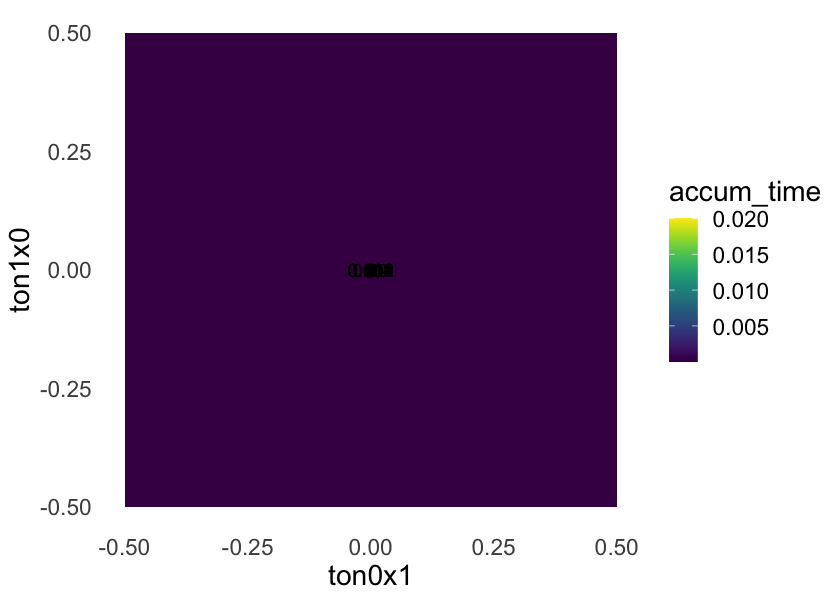

In [ ]:
ggplot(plot_df, aes(x=ton0x1, y=ton1x0)) +
    geom_tile(aes(fill = accum_time)) + 
    geom_text(aes(label = round(accum_time, 3))) +
    scale_fill_viridis() +
    # scale_fill_distiller(palette = 'PiYG',direction = 1,
    #                 limit=max(abs(plot_df$prob)) * c(-1, 1)
    #                 ) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

In [ ]:
get_exp_mat <- function(graph, rewards, s) 
{
    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index_two_locus(s, i, j), ])
      }
    } 
    return(exp_mat)
}
                 
plot_exp_mat <- function(exp_mat, title="Expectations") 
{  
    df <- as.data.frame(exp_mat) #%>% gather()
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))

    limit <- max(abs(df$value)) * c(-1, 1)
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        geom_text(aes(label = round(value, 2)), size=5) +
        ggtitle(title) +
    scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_fill_distiller(palette = 'PiYG',direction = 1, limit=limit) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

} 

exp_mat <- get_exp_mat(graph, reward_matrix, sample_size)
new_exp_mat <- get_exp_mat(new_graph, rbind(0, new_reward_matrix, 0), sample_size)

options(repr.plot.width = 20, repr.plot.height = 5, repr.plot.res = 100)

p1 <- plot_exp_mat(exp_mat, "Original graph")    
p2 <- plot_exp_mat(new_exp_mat, "Lumped graph")    
p3 <- plot_exp_mat(exp_mat - new_exp_mat, "Absolute difference")    
rel_diff <- (exp_mat - new_exp_mat)/exp_mat
rel_diff[is.na(rel_diff)] <- 0
p4 <- plot_exp_mat(rel_diff, "Relative difference")    
grid.arrange(p1, p2, p3, p4, nrow = 1)


ERROR: Error in eval(expr, envir, enclos): objekt 'reward_matrix' blev ikke fundet


# Base-n approach

## State space for joint proability computation

Generate coalescent state space like normal with the following modifications

- Change state space from (4, 0, 0, 0) to (4, 0, 0, 0, t1, t2, t3, t4). The last extra "ton" states keep track of the number accumulated mutations of each kind. We simply double the state vector so we keep track of the counts lineages with descendants, but also the counts of mutations happened on such lineages.
- Each state can mutate to accumulate a "ton" in accordance with its state vector. E.g., a `(4, 0, 0, 0, 0, 0, 0, 0)` state can only make singletons,  a `(2, 1, 0, 0, 0, 0, 0, 0)` state can only make singletons and doubletons.
- A mutation event is a transition to a siter state E.g., `(4, 0, 0, 0, 0, 0, 0, 0) -> (4, 0, 0, 0, 1, 0, 0, 0)`
- The ton counts have a maximum value (base-1). If this value is reached, the mutation transition instead leads to a trash state with an infinite self loop. The transitions to trash represents the part of the deficient PDF not covered because we only run up to a max nr of tons.

## Reward transform

- Convert the last half of each state (with ton counts) to numbers in some base.
- Use these for reward transformation.
- Compute PDF for t <- 1:sample_size^(base-1)
- Convert each time t back to the corresponding ton vector and associate it with the probability
- group by two tons and sum probs in groups to get all pairwise combinations for a joint probability matrix.

## Figure out why you get NAs in multi_rewards with max_tons <- 1

In [ ]:
# joint_prob_coalescent <- function(n, mutation_rate, max_tons, total_tons=Inf) {
    
#     state_vector_length <- n + n + 1
#     graph <- create_graph(state_vector_length)
#     starting_vertex <- vertex_at(graph, 1)
#     initial_state <- c(rep(0, n), 0)
#     initial_state[1] <- n
    
#     add_edge(
#       starting_vertex,
#       create_vertex(graph, initial_state),
#       1
#     )
#     index <- 2

#     while (index <= vertices_length(graph)) {
#       vertex <- vertex_at(graph, index)

#       # skip if we only have one lineage left or if this is a trash state
#       if (sum(vertex$state[1:n]) <= 1) {
#         index <- index + 1
#         next
#       }

#       # mutations
#       trash_rate <- 0 
#       for (i in 1:n)  {
#         state <- vertex$state          
#         rate <- vertex$state[i] * mutation_rate
#         nr_tons <- state[n+i]
#         if (rate > 0) {
#             if (nr_tons < max_tons && sum(vertex$state[(n+1):(2*n)]) < total_tons) {
#               child_state <- state

#               mutation_vertex <- create_vertex(graph, rep(0, state_vector_length))
#               add_edge(vertex, mutation_vertex, rate)
#               child_state[n+i] <- child_state[i+n] + 1
#               add_edge(mutation_vertex, find_or_create_vertex(graph, child_state), 1)
                
#               # child_state[n+i] <- child_state[i+n] + 1
#               # add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
#             } else {
#               trash_rate <- trash_rate + rate
#             }
#         }          
#       }
#       if (trash_rate > 0) {
#         add_edge(vertex, find_or_create_vertex(graph, rep(0, state_vector_length)), trash_rate)
#       }

#       # loop over all classes of lineages
#       for (i in 1:n) {
#         for (j in i:n) {
#           state <- vertex$state
          
#           # if same class, there need to be at least two to coalesce
#           if (i == j) {
#             if (state[i] < 2) {
#               next;
#             }
#             # coal rate
#             rate <- state[i] * (state[i] - 1) / 2
#           } else {
#             # else at least one in each class to coalesce
#             if (state[i] < 1 || state[j] < 1) {
#               next;
#             }
#             # number of combinations
#             rate <- state[i] * state[j]
#           }
          
#           # copy state
#           child_state <- state
#           # update child state
#           child_state[i] <- child_state[i] - 1
#           child_state[j] <- child_state[j] - 1
#           child_state[i+j] <- child_state[i+j] + 1

#           add_edge(
#               vertex,
#               find_or_create_vertex(graph, child_state),
#               rate
#             )
#         }
#       }

#       index <- index + 1
#     }
#     trash_vertex <- find_or_create_vertex(graph, rep(0, state_vector_length))
#     trash_loop_vertex <- create_vertex(graph, rep(0, state_vector_length))
#     add_edge(trash_vertex, trash_loop_vertex, 1)
#     add_edge(trash_loop_vertex, trash_vertex, 1)
    
#     return(graph)
# }
# # states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# # ipv <- graph_as_matrix(graph)$IPV
# # sim <- graph_as_matrix(graph)$SIM

# # sample_size <- 4
# # # mutation_rate <- 20000 * 31 * 5e-10 # 0.00031
# # mutation_rate <- 1
# # max_tons <- 3
# # base <- max_tons + 1
# # # graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons)
# # # gam <- graph_as_matrix(graph)
# # # #gam

# # graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons, total_tons)
# # gam <- graph_as_matrix(graph)
# # plot_graph(gam, #subgraphs=TRUE, 
# #            rainbow=TRUE,
# #            size=c(10, 8), 
# #            align=TRUE,
# #            fontsize=16, ranksep=1, nodesep=0.25,          
# #            # subgraphfun=function(state) paste(state[-length(state)], collapse="")
# #            )

In [ ]:

joint_prob_coalescent <- function(n, mutation_rate, max_tons, total_tons=Inf) {

    stopifnot(total_tons == Inf)
    
    state_vector_length <- n + n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

      # skip if we only have one lineage left or if this is a trash state
      if (sum(vertex$state[1:n]) <= 1) {
        index <- index + 1
        next
      }
        
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate
            )
        }
      }

      # mutations
      trash_rate <- 0 
      for (i in 1:n)  {
        rate <- vertex$state[i] * mutation_rate
        nr_tons <- child_state[n+i]
        if (rate > 0) {
            if (nr_tons < max_tons && sum(vertex$state[(n+1):(2*n)]) < total_tons) {
              child_state <- state
              child_state[n+i] <- child_state[i+n] + 1
              add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
            } else {
              trash_rate <- trash_rate + rate
            }
        }
      }
      if (trash_rate > 0) {
        add_edge(vertex, find_or_create_vertex(graph, rep(0, state_vector_length)), trash_rate)
      }

      index <- index + 1
    }
    trash_vertex <- find_or_create_vertex(graph, rep(0, state_vector_length))
    trash_loop_vertex <- create_vertex(graph, rep(0, state_vector_length))
    add_edge(trash_vertex, trash_loop_vertex, 1)
    add_edge(trash_loop_vertex, trash_vertex, 1)
    
    return(graph)
}

In [ ]:
ndigits <- function(x){
  y <- floor(abs(x))
  if(y != 0){
    floor(log10(y)) + 1
  } else {
    1
  }
}
rev_number=function(n){
    m=as.integer(rev(strsplit(as.character(n),"")))
    if (m==rev(m)) print("reversed number")
}
forth <- function(vec, base) {
    # return( as.integer( c(vec %*%  (base ^ rev(seq_along(vec)) / base)) ) )
    # return( as.integer( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) )
    # return( c(vec %*%  (base ^ (rev(seq_along(vec))) / base)) ) 
    return( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) 
}
back <- function(x, base, state_length) {
    # x <- as.integer(rev(paste(x, collapse='')))
    # x <- floor(as.numeric(rev(paste(x, collapse=''))))
    vec <- c()

    for (i in 1:state_length) {
        # if (x > 0) {
            vec <- c(x %% (base), vec)
            x <- x %/% (base)
        # }
    }

    # while (x > 0) {
    #     vec <- c(x %% (base), vec)
    #     x <- x %/% (base)
    # }
    
    # for (i in 1:ndigits(x)) {
    #     if (x > 0) {
    #         vec <- c(x %% (base), vec)
    #         x <- x %/% (base)
    #     }
    # }
    vec <- as.integer(vec)
    return( rev(c(rep(0, state_length-length(vec)), vec) ))
    # return( c(rep(0, state_length-length(vec)), vec) )
}
# vec <- c(1, 2, 0)
# base <- max(vec)+1
# state_length <- length(vec)
# print(vec)
# f <- forth(vec, base)
# print(f)
# b <- back(f, base, state_length)
# print(b)
# b <- c(rep(0, length(vec)-length(b)), b)
# print(b)

In [ ]:
graph <- standard_coalescent(sample_size)
graph_as_matrix(graph)

4,0,0,0
2,1,0,0
0,2,0,0
1,0,1,0
-6,6,0,0
0,-3,1,2
0,0,-1,0
0,0,0,-1


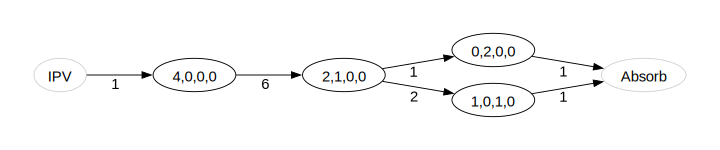

In [ ]:
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, # rainbow=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25)

In [ ]:
expectation(graph)

[1] 1.5

In [ ]:
rewards <- make_discrete(graph, 1)
graph_as_matrix(graph)

$states
      [,1] [,2] [,3] [,4]
 [1,]    0    0    0    0
 [2,]    4    0    0    0
 [3,]    0    0    0    0
 [4,]    0    0    0    0
 [5,]    2    1    0    0
 [6,]    0    0    0    0
 [7,]    0    2    0    0
 [8,]    0    0    0    0
 [9,]    0    0    0    0
[10,]    1    0    1    0

$SIM
      [,1] [,2]       [,3]       [,4] [,5]       [,6]       [,7]       [,8]
 [1,] -1.0    1  0.0000000  0.0000000  0.0  0.0000000  0.0000000  0.0000000
 [2,]  0.4   -1  0.0000000  0.0000000  0.6  0.0000000  0.0000000  0.0000000
 [3,]  0.0    0 -1.0000000  0.0000000  1.0  0.0000000  0.0000000  0.0000000
 [4,]  0.0    0  0.0000000 -1.0000000  1.0  0.0000000  0.0000000  0.0000000
 [5,]  0.0    0  0.1666667  0.3333333 -1.0  0.0000000  0.1666667  0.0000000
 [6,]  0.0    0  0.0000000  0.0000000  0.0 -1.0000000  1.0000000  0.0000000
 [7,]  0.0    0  0.0000000  0.0000000  0.0  0.6666667 -1.0000000  0.0000000
 [8,]  0.0    0  0.0000000  0.0000000  0.0  0.0000000  0.0000000 -1.0000000
 [9,]  0.0    0  0.0000000  0.0000000  0.0  0.0000000  0.0000000  0.0000000
[10,]  0.0    0  0.0000000  0.0000000  0.0  0.0000000  0.0000000  0.3333333
            [,9]      [,10]
 [1,]  0.0000000  0.0000000
 [2,]  0.0000000  0.0000000
 [3,]  0.0000000  0.0000000
 [4,]  0.0000000  0.0000000
 [5,]  0.0000000  0.3333333
 [6,]  0.0000000  0.0000000
 [7,]  0.0000000  0.0000000
 [8,]  0.0000000  1.0000000
 [9,] -1.0000000  1.0000000
[10,]  0.3333333 -1.0000000

$IPV
 [1] 0 1 0 0 0 0 0 0 0 0

$indices
 [1]  7  2  9  8  3 10  4 12 11  5

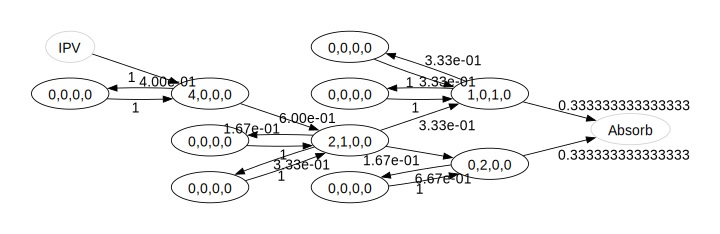

In [ ]:
plot_graph(graph_as_matrix(graph), #rainbow=TRUE, 
           size=c(10, 8), #align=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25,
             # subgraph=TRUE, subgraphfun=function(state, index) as.character((index+1) %/% 2)
)

In [ ]:
apply(rewards[1:3,], 1, function(x) expectation(graph, x))

[1] 2.0000000 1.0000000 0.6666667

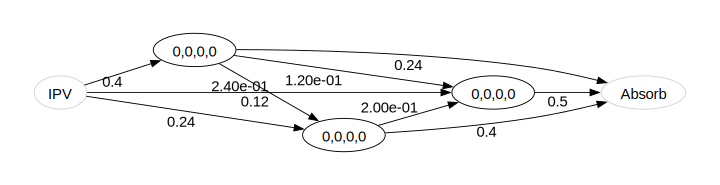

In [ ]:
rev_graph <- reward_transform(graph, rewards[1,])
plot_graph(graph_as_matrix(rev_graph), #rainbow=TRUE, 
           size=c(10, 8), #align=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25,
             # subgraph=TRUE, subgraphfun=function(state, index) as.character((index+1) %/% 2)
)

In [ ]:
pdph(1:10, rev_graph)

[1] 0.4920000 0.6852000 0.8144400 0.8944200 0.9414756 0.9681983 0.9829850
 [8] 0.9910075 0.9952941 0.9975569

## Compute joint prob

> **Constraining the total number of mutations does not work**
> 
> The deficit is computed correctly as long as all max rewards so that all r scalar values in the CDF represents a reward combination in the MDF
> 
> Just like we can limit the number of each king of tons in the state space contruction, we might also limit the total number of mutations so that we, for example, can have at most one instance of two different tons (`total_tons=2`). E.g., a singleton and a tripleton.
> 
> However, this gives a a deficit problem I am not sure I can solve with this approach. In principle, the deficit should be taken care of, and I should just discard all joint probs for total numbers of tons larger than `total_tons` - but that does not seem to be the case...

**maybe I don't need loops if they are not selff-loops anyway. If aux->C has rate 1 then A->aux->C is the same as A->C. Below I just changed two things**

1. normalize the graph
2. use pdph instead of pph

**BUT** if I normalize I need to represent the residual prob as reward, which means I need to reward transform, which I cannot if I want to do everying in one go with the scalar trick. 

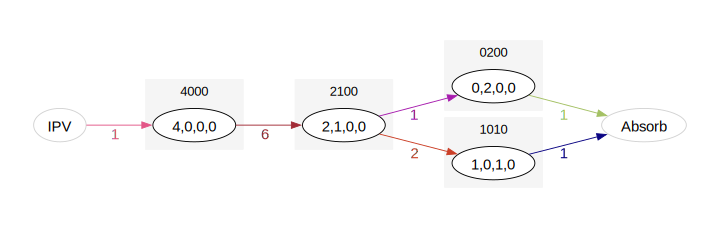

In [ ]:
sample_size <- 4

graph <- standard_coalescent(sample_size)
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, rainbow=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25,
            subgraphs=TRUE,         
           subgraphfun=function(state, index) paste(state[1:sample_size], collapse=""))

In [ ]:
# mutation_rate <- 20000 * 31 * 5e-10 # 0.00031
mutation_rate <- 1
max_tons <- 20
total_tons <- Inf
base <- max_tons + 1
graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons, total_tons=total_tons)

weights_were_multiplied_with <- normalize_graph(graph)

# gam <- graph_as_matrix(graph)
#gam

In [ ]:
if (vertices_length(graph) < 50)
    plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, rainbow=TRUE,
               fontsize=16, ranksep=2, nodesep=0.5,
             subgraphs=TRUE,         
           subgraphfun=function(state, index) paste(state[1:sample_size], collapse=""))

Get last halves of states that server as mutation rewards:

In [ ]:
rewards <- states(graph)[, (sample_size+1):(2*sample_size)]

Turn reward vectors into scalars (with the appropriate base):

In [ ]:
multi_rewards <- apply(rewards, 1, forth, base=base)
multi_rewards

[1]    0    0    0    1    0    0    1   21    2    0   21    1  441    1
   [15]    2   22   21   42    3   21   42    1    2  442  441  882   22    2
   [29]    3   23   22   43  462   42   63    4   42   63    2    3  443  442
   [43]  883  882 1323   22   43   23    3    4   24   23   44  463   43   64
   [57]  462  903  483   63   84    5   63   84    3    4  444  443  884  883
   [71] 1324 1323 1764   43   64   23   44   24    4    5   25   24   45  464
   [85]   44   65  463  904  484   64   85  903 1344  483  924  504   84  105
   [99]    6   84  105    4    5  445  444  885  884 1325 1324 1765 1764 2205
  [113]   64   85   44   65   24   45   25    5    6   26   25   46  465   45
  [127]   66  464  905  485   65   86  904 1345  484  925  505   85  106 1344
  [141] 1785  924 1365  504  945  525  105  126    7  105  126    5    6  446
  [155]  445  886  885 1326 1325 1766 1765 2206 2205 2646   85  106   65   86
  [169]   45   66   25   46   26    6    7   27   26   47  466   46   67  465
  [183]  906  486   66   87  905 1346  485  926  506   86  107 1345 1786  925
  [197] 1366  505  946  526  106  127 1785 2226 1365 1806  945 1386  525  966
  [211]  546  126  147    8  126  147    6    7  447  446  887  886 1327 1326
  [225] 1767 1766 2207 2206 2647 2646 3087  106  127   86  107   66   87   46
  [239]   67   26   47   27    7    8   28   27   48  467   47   68  466  907
  [253]  487   67   88  906 1347  486  927  507   87  108 1346 1787  926 1367
  [267]  506  947  527  107  128 1786 2227 1366 1807  946 1387  526  967  547
  [281]  127  148 2226 2667 1806 2247 1386 1827  966 1407  546  987  567  147
  [295]  168    9  147  168    7    8  448  447  888  887 1328 1327 1768 1767
  [309] 2208 2207 2648 2647 3088 3087 3528  127  148  107  128   87  108   67
  [323]   88   47   68   27   48   28    8    9   29   28   49  468   48   69
  [337]  467  908  488   68   89  907 1348  487  928  508   88  109 1347 1788
  [351]  927 1368  507  948  528  108  129 1787 2228 1367 1808  947 1388  527
  [365]  968  548  128  149 2227 2668 1807 2248 1387 1828  967 1408  547  988
  [379]  568  148  169 2667 3108 2247 2688 1827 2268 1407 1848  987 1428  567
  [393] 1008  588  168  189   10  168  189    8    9  449  448  889  888 1329
  [407] 1328 1769 1768 2209 2208 2649 2648 3089 3088 3529 3528 3969  148  169
  [421]  128  149  108  129   88  109   68   89   48   69   28   49   29    9
  [435]   10   30   29   50  469   49   70  468  909  489   69   90  908 1349
  [449]  488  929  509   89  110 1348 1789  928 1369  508  949  529  109  130
  [463] 1788 2229 1368 1809  948 1389  528  969  549  129  150 2228 2669 1808
  [477] 2249 1388 1829  968 1409  548  989  569  149  170 2668 3109 2248 2689
  [491] 1828 2269 1408 1849  988 1429  568 1009  589  169  190 3108 3549 2688
  [505] 3129 2268 2709 1848 2289 1428 1869 1008 1449  588 1029  609  189  210
  [519]   11  189  210    9   10  450  449  890  889 1330 1329 1770 1769 2210
  [533] 2209 2650 2649 3090 3089 3530 3529 3970 3969 4410  169  190  149  170
  [547]  129  150  109  130   89  110   69   90   49   70   29   50   30   10
  [561]   11   31   30   51  470   50   71  469  910  490   70   91  909 1350
  [575]  489  930  510   90  111 1349 1790  929 1370  509  950  530  110  131
  [589] 1789 2230 1369 1810  949 1390  529  970  550  130  151 2229 2670 1809
  [603] 2250 1389 1830  969 1410  549  990  570  150  171 2669 3110 2249 2690
  [617] 1829 2270 1409 1850  989 1430  569 1010  590  170  191 3109 3550 2689
  [631] 3130 2269 2710 1849 2290 1429 1870 1009 1450  589 1030  610  190  211
  [645] 3549 3990 3129 3570 2709 3150 2289 2730 1869 2310 1449 1890 1029 1470
  [659]  609 1050  630  210  231   12  210  231   10   11  451  450  891  890
  [673] 1331 1330 1771 1770 2211 2210 2651 2650 3091 3090 3531 3530 3971 3970
  [687] 4411 4410 4851  190  211  170  191  150  171  130  151  110  131   90
  [701]  111   70   91   50   71   30   51   31   11   12   32   31   52  471
  [715]   51   72  470  91

Loop over states except starting to find trash vertices and give them a reward so they won't dissapear in the reward transformation. They will not contribute this reward because they are dead ends:

In [ ]:
trash_states <- c()
for (i in 2:vertices_length(graph)) {
  vertex <- vertex_at(graph, i)
  if (sum(vertex$state) == 0) {
    multi_rewards[i] <- 1
    trash_states <- c(trash_states, i)
  }
}
trash_states

[1]  3334 19428

In [ ]:
multi_rewards

[1]    0    0    0    1    0    0    1   21    2    0   21    1  441    1
   [15]    2   22   21   42    3   21   42    1    2  442  441  882   22    2
   [29]    3   23   22   43  462   42   63    4   42   63    2    3  443  442
   [43]  883  882 1323   22   43   23    3    4   24   23   44  463   43   64
   [57]  462  903  483   63   84    5   63   84    3    4  444  443  884  883
   [71] 1324 1323 1764   43   64   23   44   24    4    5   25   24   45  464
   [85]   44   65  463  904  484   64   85  903 1344  483  924  504   84  105
   [99]    6   84  105    4    5  445  444  885  884 1325 1324 1765 1764 2205
  [113]   64   85   44   65   24   45   25    5    6   26   25   46  465   45
  [127]   66  464  905  485   65   86  904 1345  484  925  505   85  106 1344
  [141] 1785  924 1365  504  945  525  105  126    7  105  126    5    6  446
  [155]  445  886  885 1326 1325 1766 1765 2206 2205 2646   85  106   65   86
  [169]   45   66   25   46   26    6    7   27   26   47  466   46   67  465
  [183]  906  486   66   87  905 1346  485  926  506   86  107 1345 1786  925
  [197] 1366  505  946  526  106  127 1785 2226 1365 1806  945 1386  525  966
  [211]  546  126  147    8  126  147    6    7  447  446  887  886 1327 1326
  [225] 1767 1766 2207 2206 2647 2646 3087  106  127   86  107   66   87   46
  [239]   67   26   47   27    7    8   28   27   48  467   47   68  466  907
  [253]  487   67   88  906 1347  486  927  507   87  108 1346 1787  926 1367
  [267]  506  947  527  107  128 1786 2227 1366 1807  946 1387  526  967  547
  [281]  127  148 2226 2667 1806 2247 1386 1827  966 1407  546  987  567  147
  [295]  168    9  147  168    7    8  448  447  888  887 1328 1327 1768 1767
  [309] 2208 2207 2648 2647 3088 3087 3528  127  148  107  128   87  108   67
  [323]   88   47   68   27   48   28    8    9   29   28   49  468   48   69
  [337]  467  908  488   68   89  907 1348  487  928  508   88  109 1347 1788
  [351]  927 1368  507  948  528  108  129 1787 2228 1367 1808  947 1388  527
  [365]  968  548  128  149 2227 2668 1807 2248 1387 1828  967 1408  547  988
  [379]  568  148  169 2667 3108 2247 2688 1827 2268 1407 1848  987 1428  567
  [393] 1008  588  168  189   10  168  189    8    9  449  448  889  888 1329
  [407] 1328 1769 1768 2209 2208 2649 2648 3089 3088 3529 3528 3969  148  169
  [421]  128  149  108  129   88  109   68   89   48   69   28   49   29    9
  [435]   10   30   29   50  469   49   70  468  909  489   69   90  908 1349
  [449]  488  929  509   89  110 1348 1789  928 1369  508  949  529  109  130
  [463] 1788 2229 1368 1809  948 1389  528  969  549  129  150 2228 2669 1808
  [477] 2249 1388 1829  968 1409  548  989  569  149  170 2668 3109 2248 2689
  [491] 1828 2269 1408 1849  988 1429  568 1009  589  169  190 3108 3549 2688
  [505] 3129 2268 2709 1848 2289 1428 1869 1008 1449  588 1029  609  189  210
  [519]   11  189  210    9   10  450  449  890  889 1330 1329 1770 1769 2210
  [533] 2209 2650 2649 3090 3089 3530 3529 3970 3969 4410  169  190  149  170
  [547]  129  150  109  130   89  110   69   90   49   70   29   50   30   10
  [561]   11   31   30   51  470   50   71  469  910  490   70   91  909 1350
  [575]  489  930  510   90  111 1349 1790  929 1370  509  950  530  110  131
  [589] 1789 2230 1369 1810  949 1390  529  970  550  130  151 2229 2670 1809
  [603] 2250 1389 1830  969 1410  549  990  570  150  171 2669 3110 2249 2690
  [617] 1829 2270 1409 1850  989 1430  569 1010  590  170  191 3109 3550 2689
  [631] 3130 2269 2710 1849 2290 1429 1870 1009 1450  589 1030  610  190  211
  [645] 3549 3990 3129 3570 2709 3150 2289 2730 1869 2310 1449 1890 1029 1470
  [659]  609 1050  630  210  231   12  210  231   10   11  451  450  891  890
  [673] 1331 1330 1771 1770 2211 2210 2651 2650 3091 3090 3531 3530 3971 3970
  [687] 4411 4410 4851  190  211  170  191  150  171  130  151  110  131   90
  [701]  111   70   91   50   71   30   51   31   11   12   32   31   52  471
  [715]   51   72  470  91

Reward transform graph using scalar rewards:

In [ ]:
rew_graph <- reward_transform(graph, multi_rewards)

In [ ]:
if (vertices_length(graph) < 50)
    plot_graph(graph_as_matrix(rew_graph),
           rainbow=TRUE,
           size=c(8, 8), 
           align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5, 
           # subgraphs=TRUE, subgraphfun=function(state, index) as.character((index+1) %/% 2)
           )

Compute CDF assming no mutation count exceeds `max_tons`:

In [ ]:
cdf_df <- data.frame(t=seq(0, base^(sample_size-1) - 1, 1))
cdf_df['cdf'] <- sapply(cdf_df$t, function (t) pdph(t, rew_graph))
# cdf_df['cdf'] <- sapply(cdf_df$t, function (t) pph(t, rew_graph))
tail(cdf_df)

,t,cdf
,<dbl>,<dbl>
9256,9255,0.9796789
9257,9256,0.9796824
9258,9257,0.9796860
9259,9258,0.9796896
9260,9259,0.9796932
9261,9260,0.9796968


Convert reward scalars back into state vectors representing ton counts:

In [ ]:
x <- lapply(cdf_df$t, back, base=base, state_length=sample_size)
m <- do.call(rbind, x)

In [ ]:
# is_additional_deficit <- as.integer(rowSums(m) > total_tons)
# p <- df$cdf
# pdf_from_cdf <- c(p[1], p[2:length(p)] - p[-length(p)])
# additional_deficit <- cumsum(pdf_from_cdf * is_additional_deficit)
# additional_deficit

In [ ]:
df <- cbind(cdf_df, data.frame(m))
tail(df)

,t,cdf,X1,X2,X3,X4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9256,9255,0.9796789,15,20,20,0
9257,9256,0.9796824,16,20,20,0
9258,9257,0.9796860,17,20,20,0
9259,9258,0.9796896,18,20,20,0
9260,9259,0.9796932,19,20,20,0
9261,9260,0.9796968,20,20,20,0


The deficit is taken care of, so you should discard all joint probs for total numbers of tons larger than `total_tons`:

In [ ]:
# df <- df[!is_additional_deficit, ]
# df

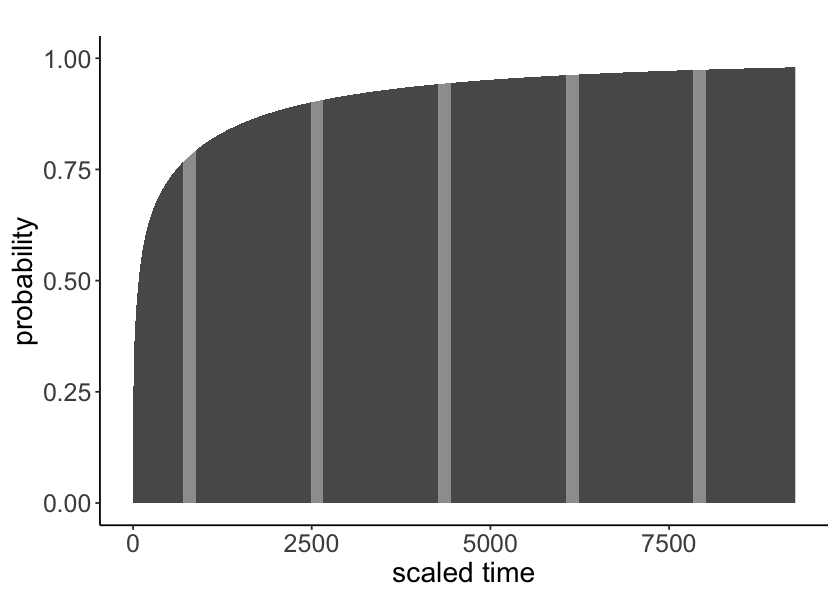

In [ ]:
df %>% ggplot(aes(x=t, y=cdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + ylim(0, 1)

Compute probability of standing in on of the trash states for each time t in our CDF. These represent the deficit of the computed CDF:

> Make sure the stop_probability is the discrete version of that is what we are doing

In [ ]:
trash_prob <- c()
for (t in df$t) {
    # s <- stop_probability(graph, t)
    s <- dph_stop_probability(graph, t)
    trash_prob <- c(trash_prob, sum(s[trash_states]))
}
df['cdf_deficit'] <- trash_prob
head(df)

,t,cdf,X1,X2,X3,X4,cdf_deficit
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.1000000,0,0,0,0,0
2,1,0.1233308,1,0,0,0,0
3,2,0.1614973,2,0,0,0,0
4,3,0.2117425,3,0,0,0,0
5,4,0.2303889,4,0,0,0,0
6,5,0.2476603,5,0,0,0,0


CDF deficit:

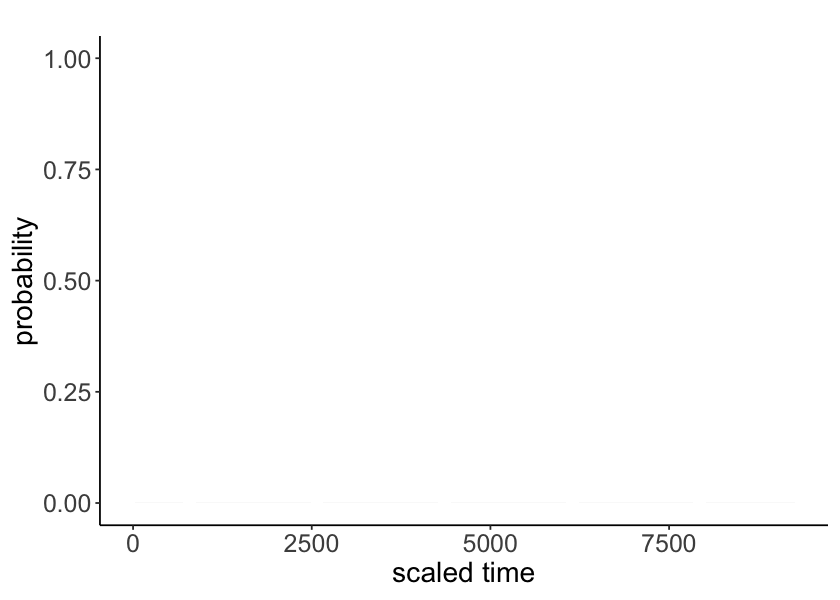

In [ ]:
df %>% ggplot(aes(x=t, y=cdf_deficit)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + ylim(0, 1)

Sanity check: adding CDF and deficit should produce a CDF that goes to 1:

In [ ]:
df['cdf_incl_deficit'] <- df$cdf + df$cdf_deficit

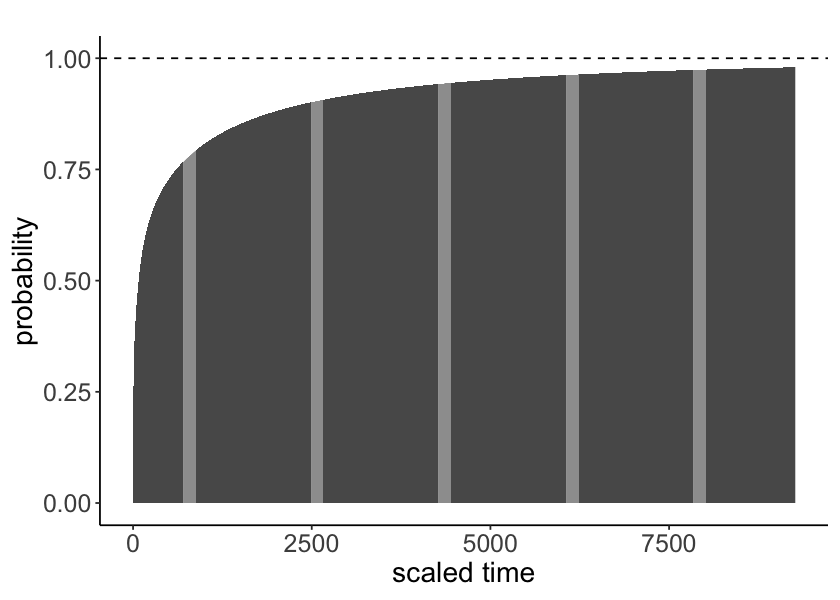

In [ ]:
df %>% ggplot(aes(x=t, y=cdf_incl_deficit)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + 
    ylim(0, 1) + 
    geom_hline(yintercept=1, linetype="dashed")

I.e., and a PDF that sum to one:

In [ ]:
p <- df$cdf_incl_deficit
df['pdf_from_cdf_incl_deficit'] <- c(p[1], p[2:length(p)] - p[-length(p)])

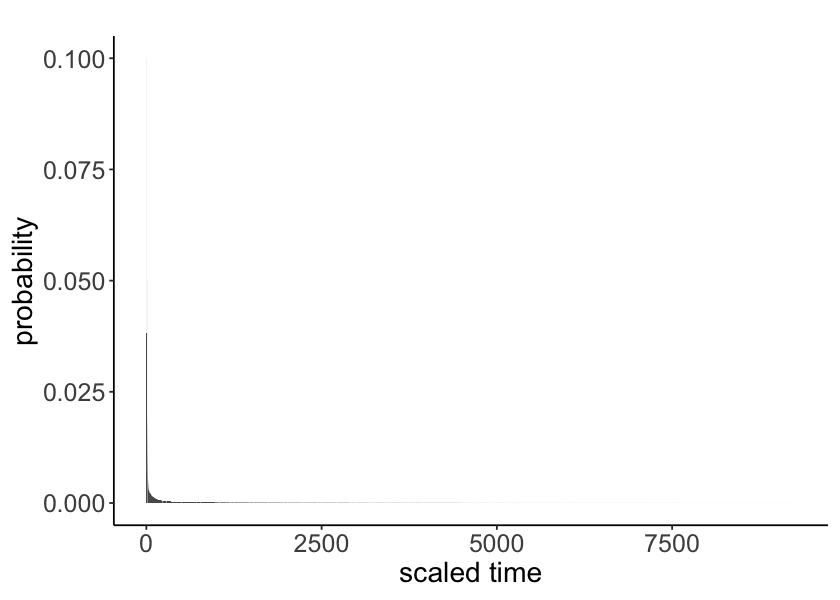

In [ ]:
df %>% ggplot(aes(x=t, y=pdf_from_cdf_incl_deficit)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine

In [ ]:
sum(df$pdf_from_cdf_incl_deficit)

[1] 0.9797801

It **almost** does... Maybe a numerical issue

Compute PDF from the CDF (**this is the one we are after**):

In [ ]:
p <- df$cdf
df['pdf_from_cdf'] <- c(p[1], p[2:length(p)] - p[-length(p)])
df['prob'] = df$pdf_from_cdf

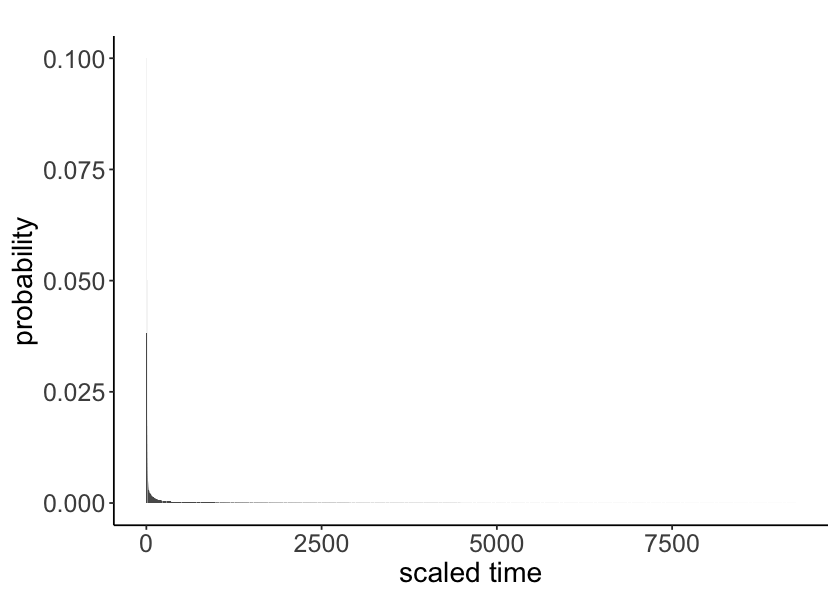

In [ ]:
df %>% ggplot(aes(x=t, y=pdf_from_cdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine

The reason we need to go through the CDF to get the PDF is that the PDF function in PtD computes the distribution of times when the absorbing state is reached. It this cannot take the deficit in trash_states into account. The PDF commputed directly looks like this:

> Make sure I ues the discrete version here if I also use the dicscrete CDF above

In [ ]:
# df['pdf'] <- sapply(df$t, function (t) dph(t, rew_graph))
df['pdf'] <- sapply(df$t, function (t) ddph(t, rew_graph))

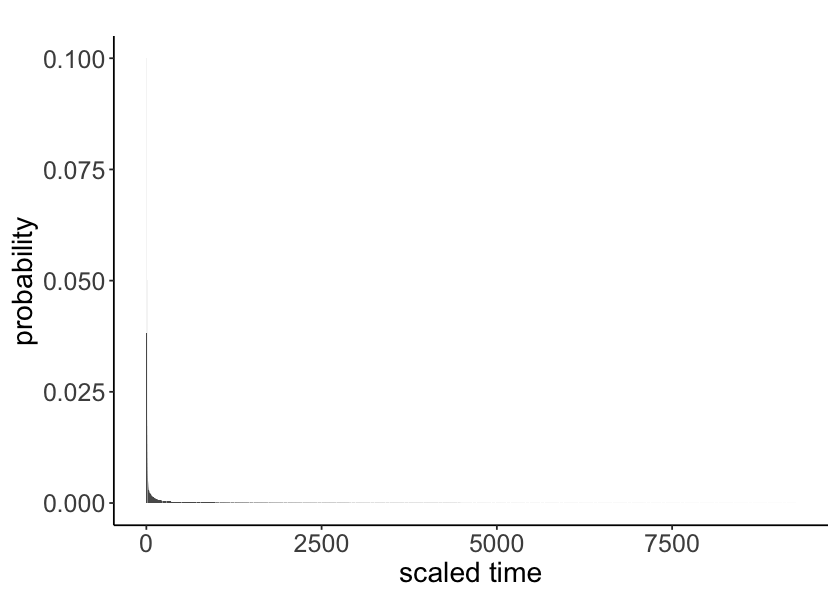

In [ ]:
df %>% ggplot(aes(x=t, y=pdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine 

## When we do the discrete version, we don't need to go through the CDF to get the PDF. We can just use the `ddph` directly

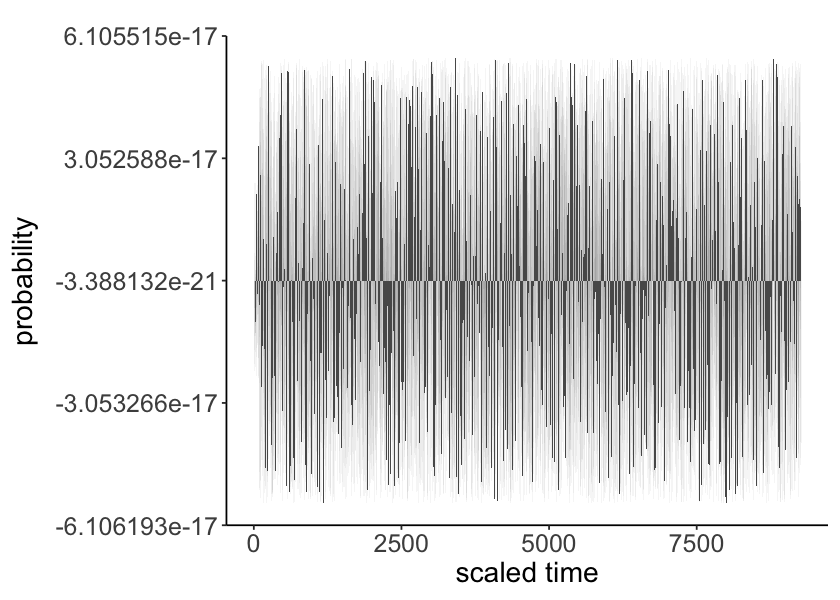

In [ ]:
df['diff'] <- df['pdf_from_cdf'] - df['pdf']
df %>% ggplot(aes(x=t, y=diff)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine 


The marginal expectations does not match the SFS proportions, because paths that accumulate more than `max_tons` singletons will end in the trash state and not have the opportunity to also accumulate doubletons etc. That reflects that the the joint prob of a singleton *and* a doubleton is be a subset of the singleton probability. That way the total marginal singleton prob will be roughly sfs expectation, but the total marginal doubleton prob will be much too small:

In [ ]:
sfs <- c(1, 1/2, 1/3)
sfs / sum(sfs)

[1] 0.5454545 0.2727273 0.1818182

In [ ]:
df[df$X1==1 & df$X2==0 & df$X3==1, ]

,t,cdf,X1,X2,X3,X4,cdf_deficit,cdf_incl_deficit,pdf_from_cdf_incl_deficit,pdf_from_cdf,prob,pdf,diff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
443,442,0.7136648,1,0,1,0,8.327853e-05,0.7137481,0.0002646858,0.0002646858,0.0002646858,0.0002646858,-2.238877e-17


In [ ]:
df

t,cdf,X1,X2,X3,X4,cdf_deficit,cdf_incl_deficit,pdf_from_cdf_incl_deficit,pdf_from_cdf,prob,pdf,diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.1000000,0,0,0,0,0.000000e+00,0.1000000,0.100000000,0.100000000,0.100000000,0.100000000,0.000000e+00
1,0.1233308,1,0,0,0,0.000000e+00,0.1233308,0.023330814,0.023330814,0.023330814,0.023330814,-6.938894e-18
2,0.1614973,2,0,0,0,0.000000e+00,0.1614973,0.038166529,0.038166529,0.038166529,0.038166529,-6.938894e-18
3,0.2117425,3,0,0,0,0.000000e+00,0.2117425,0.050245196,0.050245196,0.050245196,0.050245196,6.938894e-18
4,0.2303889,4,0,0,0,0.000000e+00,0.2303889,0.018646386,0.018646386,0.018646386,0.018646386,-3.469447e-18
5,0.2476603,5,0,0,0,0.000000e+00,0.2476603,0.017271404,0.017271404,0.017271404,0.017271404,-1.387779e-17
6,0.2629493,6,0,0,0,0.000000e+00,0.2629493,0.015288932,0.015288932,0.015288932,0.015288932,2.428613e-17
7,0.2762541,7,0,0,0,0.000000e+00,0.2762541,0.013304841,0.013304841,0.013304841,0.013304841,5.204170e-18
8,0.2878150,8,0,0,0,0.000000e+00,0.2878150,0.011560939,0.011560939,0.011560939,0.011560939,-1.040834e-17


In [ ]:
c(sum(joint_probs$V1 * joint_probs$accum_time), 
  sum(joint_probs$V2 * joint_probs$accum_time), 
  sum(joint_probs$V3 * joint_probs$accum_time))

[1] 0.0000000000 0.0009615983 0.0005794837

In [ ]:
c(sum(df$X1 * df$prob), sum(df$X2 * df$prob), sum(df$X3 * df$prob))

[1] 7.731127 4.694250 1.192503

In [ ]:
plot_df <- df %>% group_by(X2, X3) %>% summarise(prob = sum(prob))
plot_df[,-ncol(plot_df)] <- lapply(plot_df[,-ncol(plot_df)], as.factor)
head(plot_df)

`summarise()` has grouped output by 'X2'. You can override using the `.groups` argument.


X2,X3,prob
<fct>,<fct>,<dbl>
0,0,0.3637069369
0,1,0.0054461936
0,2,0.0026874034
0,3,0.0016935722
0,4,0.0011754205
0,5,0.0008663035


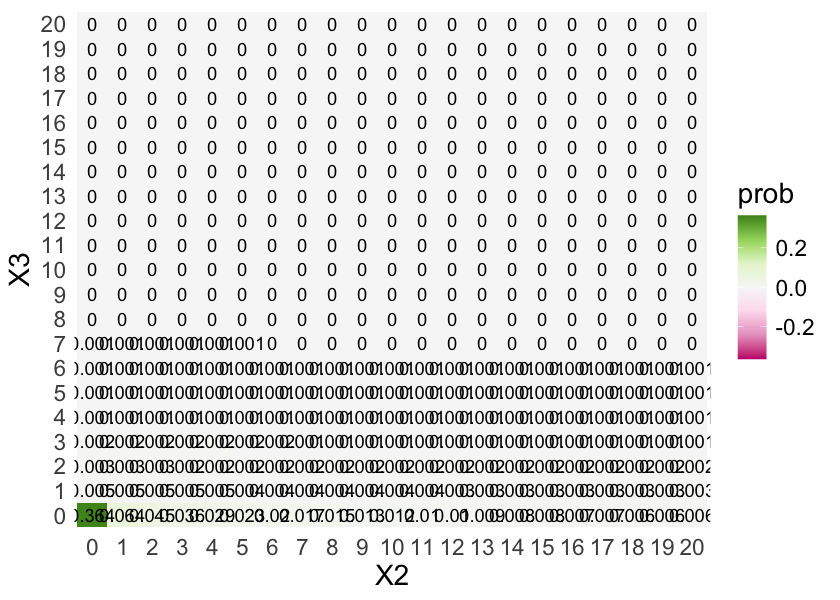

In [ ]:
ggplot(plot_df, aes(x=X2, y=X3)) +
    geom_tile(aes(fill = prob)) + 
    geom_text(aes(label = round(prob, 3))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(plot_df$prob)) * c(-1, 1)
                    ) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

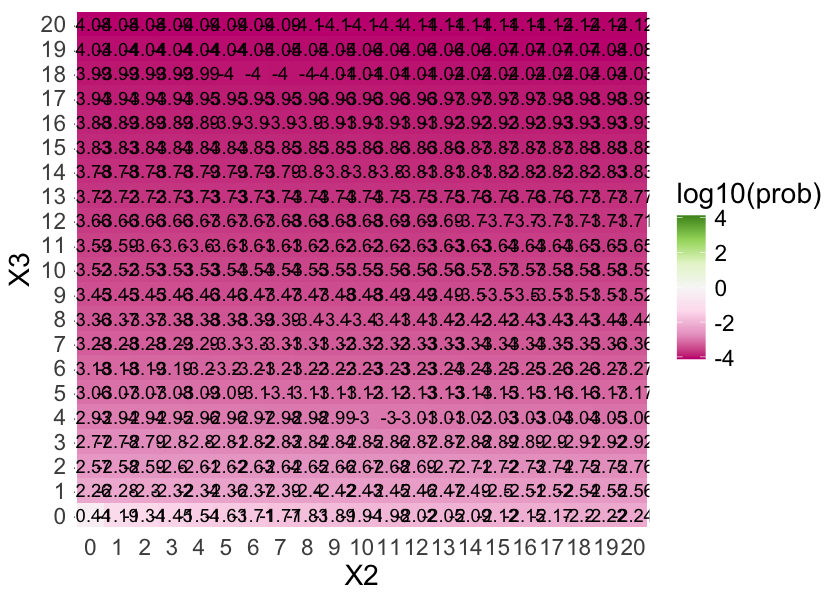

In [ ]:
ggplot(plot_df, aes(x=X2, y=X3)) +
    geom_tile(aes(fill = log10(prob))) + 
    geom_text(aes(label = round(log10(prob), 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(log10(plot_df$prob))) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))


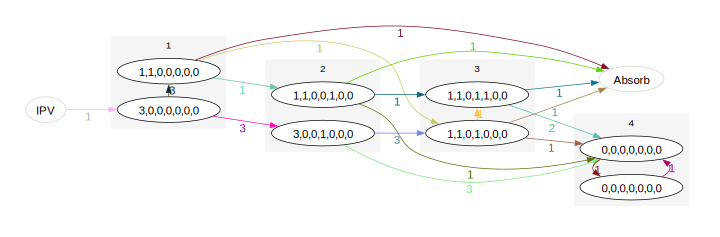

In [ ]:

# plot_graph <- function(gam, constrained=TRUE, 
#                        subgraphs=FALSE, ranksep=2, nodesep=1,
#                        subgraphfun=function(state, index) paste(state[-length(state)], collapse=""), 
#                        size=c(6, 6), fontsize=10, rankdir="LR", align=FALSE, nodecolor='white', rainbow=FALSE, penwidth=1) {


#     format_rate <- function(rate) {
#         # tol = .Machine$double.eps^0.5
#         # if (min(abs(c(rate%%1, rate%%1-1))) < tol) {
#         if (rate == round(rate)) {
#             return(rate)
#         } else {
#             return(formatC(rate, format = "e", digits = 2))
#         }
#     }

#     random_color <- function() {
#         if (rainbow) {
#             return(paste("#", paste0(sample(c(0:9, LETTERS[1:6]), 6, T), collapse = ''), sep=''))
#         } else {
#             return('#000000')
#         }
#     }

#     sub_graphs = list()
#     state_classes = list()
    
#     if (constrained) {
#         constrained <- 'true'
#     } else {
#         constrained <- 'false'
#     }

#     states <- c()
#     for (i in 1:(nrow(gam$states))) {
#         states <- c(states, paste0(i, ' [label="', paste(gam$states[i,], collapse = ","), '"];'))
#     }
    
#     edge_templ <- '"FROM" -> "TO" [constraint=true, label="LABEL",labelfloat=false,color="COLOR",fontcolor="COLOR"];'

#     subgraph_template <- '
#     subgraph cluster_FREQBIN {
#         rank=same;
#         style=filled;
#         color=whitesmoke;
#         node [style=filled];
#         NODES;
#         label = "FREQBIN";
#     }
#     '
#     start_name <- 'IPV'
#     absorbing_name <- 'Absorb'
#     edges <- c()
#     # IPV edges
#     for (i in 1:length(gam$IPV)) {
#         if (gam$IPV[i] > 0) {
#             edge <- edge_templ
#             edge <- sub('FROM', start_name, edge)
#             edge <- sub('TO', i, edge)
#             edge <- sub('LABEL', gam$IPV[i], edge)
#             edge <- gsub('COLOR', random_color(), edge)                        
#             edges <- c(edges, edge)
#         }
#     }    
#     # Matrix edges
#     for (i in 1:(nrow(gam$states))) {
#         for (j in 1:nrow(gam$states)) {
#             if ((i != j) && (gam$SIM[i, j] > 0)) {
#                 edge <- edge_templ
#                 edge <- sub('FROM', i, edge)
#                 edge <- sub('TO', j, edge)
#                 edge <- sub('LABEL', format_rate(gam$SIM[i, j]), edge)
#                 edge <- gsub('COLOR', random_color(), edge)
#                 edges <- c(edges, edge)
#             }
#         }
#     }

#     absorb_rates <- -rowSums(gam$SIM)
#     for (i in 1:nrow(gam$states)) {

#         # TODO: Avoid the hack below by changing the function to use the graph instead of the matrix
#         if (absorb_rates[i] > abs(1e-14)) {
#         # if (absorb_rates[i] > 0) {
#             edge <- edge_templ
#             edge <- sub('FROM', i, edge)
#             edge <- sub('TO', absorbing_name, edge)
#             edge <- sub('LABEL', absorb_rates[i], edge)
#             edge <- gsub('COLOR', random_color(), edge)            
#             edges <- c(edges, edge)
#         }
#     }

#     graph_spec <- paste(c(states, edges), collapse = '\n')

#     rank_same <- ''

#     if (subgraphs) {        
#         for (i in 1:(nrow(gam$states))) {
#             sg <- subgraphfun(gam$states[i,], index=i)
#             sub_graphs[[sg]] <- c(sub_graphs[[sg]], i)
#         }
#         for (sg in labels(sub_graphs)) {
            
#             nodes <- sub_graphs[[sg]]
#             tmpl <- subgraph_template
#             node_str <- ''
#             for (i in 1:length(nodes)) {
#                 node_str <- paste(node_str, paste('"', nodes[i], '" ', sep=''), sep=' ')
#             }
#             tmpl <- sub('NODES', node_str, tmpl)
#             tmpl <- sub('FREQBIN', sg, tmpl)            
#             tmpl <- sub('FREQBIN', sg, tmpl)            
#             graph_spec <- paste(graph_spec, tmpl)
#         }


#         if (align) {
#             for (i in 1:(nrow(gam$states))) {
#                 sc <- paste(head(gam$states[i,], -1), collapse = ",")
#                 state_classes[[sc]] <- c(state_classes[[sc]], i)
#             }
#             for (sc in labels(state_classes)) {
#                 rank_same <- paste(rank_same, '{rank=same; ', sep='')
#                 nodes <- state_classes[[sc]]
#                 for (i in 1:length(nodes)) {
#                     rank_same <- paste(rank_same, paste('"', nodes[i], '" ', sep=''), sep=' ')
#                 }            
#                 rank_same <- paste(rank_same, ' }', sep='\n')
#             }
#         }
    
#     }

#     style_str <- '
#         graph [compound=true newrank=true pad="0.5", ranksep="RANKSEP", nodesep="NODESEP"] 
#         rankdir=RANKDIR;
#         size="SIZEX,SIZEY";
#         fontname="Helvetica,Arial,sans-serif"
#     	node [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE, style=filled, fillcolor="NODECOLOR"]
#     	edge [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE, penwidth=PENWIDTH]
#         Absorb [style=filled,color="lightgrey"]
#         IPV [style=filled,color="lightgrey"]
#         RANKSAME
#     '
#     style_str <- sub('SIZEX', size[1], style_str)
#     style_str <- sub('SIZEY', size[2], style_str)
#     style_str <- gsub('FONTSIZE', fontsize, style_str)    
#     style_str <- gsub('RANKDIR', rankdir, style_str)    
#     style_str <- gsub('RANKSAME', rank_same, style_str)
#     style_str <- gsub('RANKSEP', ranksep, style_str)
#     style_str <- gsub('NODESEP', nodesep, style_str)
#     graph_string <- paste('digraph G {', style_str, graph_spec, '}', sep='\n')
#     graph_string <- gsub('NODECOLOR', nodecolor, graph_string)  
#     graph_string <- gsub('PENWIDTH', penwidth, graph_string)  
#     system("dot -Tsvg -o tmp.svg", input=graph_string, intern=TRUE)
#     return(display_svg(file="tmp.svg"))
# }
                  
sample_size <- 3
mutation_rate <- 1
max_tons <- 1
total_tons <- Inf
base <- max_tons + 1
graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons, total_tons=total_tons)

plot_graph(graph_as_matrix(graph), rainbow=TRUE, size=c(10, 8), align=TRUE,
           fontsize=16, ranksep=1, nodesep=0.25,
           subgraphs=TRUE,
           # rankdir="TB",
           subgraphfun=function(state, index) as.character((index+1) %/% 2)
           # subgraphfun=function(state, index) paste(state[-length(state)], collapse="")
)